# testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-05-16 notebook with a focus on comapring the different fitting techniques and model formulations
 * plots have been added and improved
 * this is to test compare different models and quickly visualize fit to observations and division
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

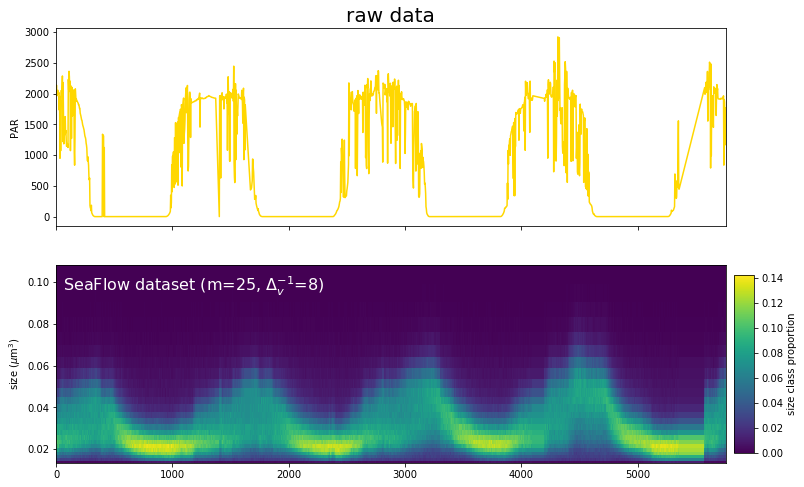

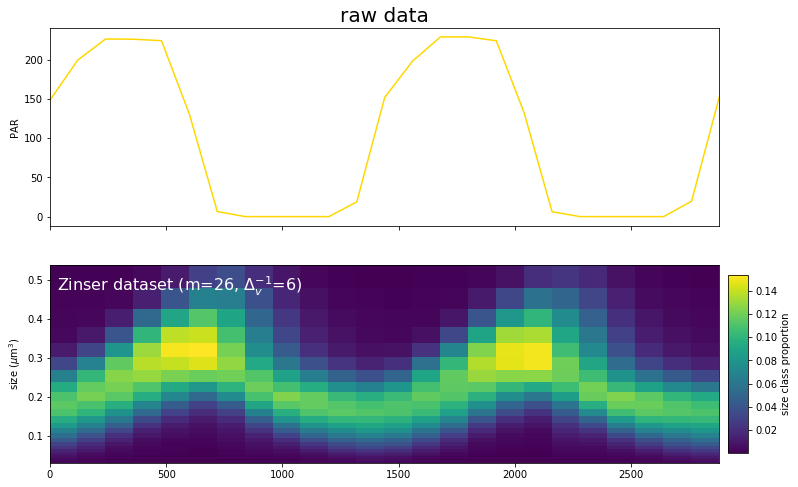

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

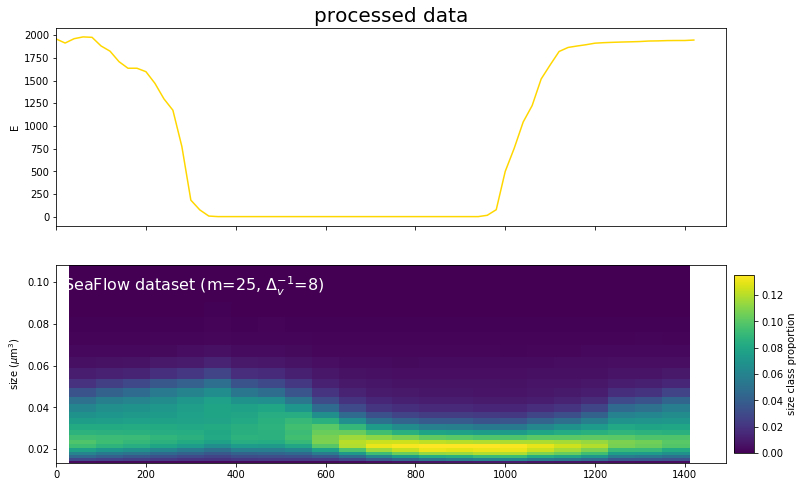

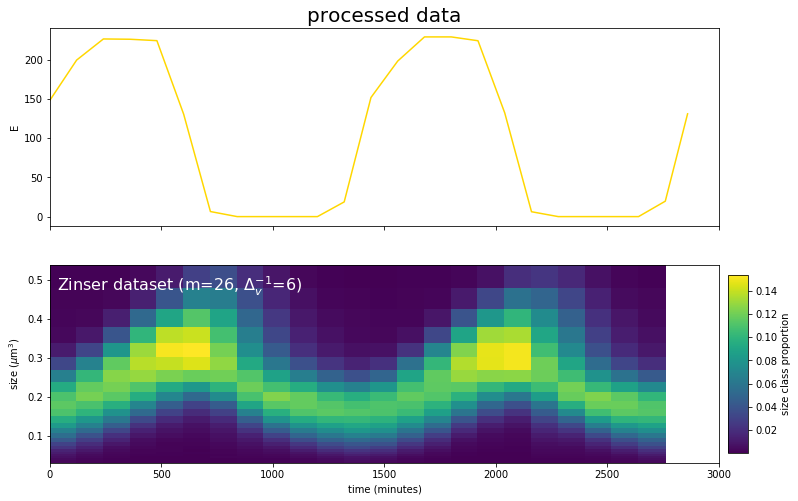

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    'monodelta_respv2':'stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    #'monodelta_respv2_mn_lightsig':'stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respiv6_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv6_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv6_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv7_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv7_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv7_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',   
}
desc_model = {
    'monodelta_respv2':'respiration v2 (no size-dep), old fit (for comparison only)',
    'monodelta_respv2_mn':'respiration v2 (no size-dep), multinomial',
    'monodelta_respv2_mlmn':'respiration v2 (no size-dep), multilevel multinomial',
    'monodelta_respv2_mn_lightsig':'OLD: respiration v2 (no size-dep), light-dep div',
    'monodelta_respiv6_mn':'size-dep growth/resp v6, multinomial',
    'monodelta_respiv6_mlmn':'size-dep growth/resp v6, multilevel multinomial',
    'monodelta_respiv6_mn_lightsig':'size-dep growth/resp v6, multinomial, light-dep div',
    'monodelta_respiv7_mn':'size-dep growth/resp v7, multinomial',
    'monodelta_respiv7_mlmn':'size-dep growth/resp v7, multilevel multinomial',
    'monodelta_respiv7_mn_lightsig':'size-dep growth/resp v7, multinomial, light-dep div',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respv2 NOW.


monodelta_respv2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respv2_mn NOW.


monodelta_respv2_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respv2_mlmn NOW.


monodelta_respv2_mlmn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv6_mn NOW.


monodelta_respiv6_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv6_mlmn NOW.


monodelta_respiv6_mlmn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv7_mn NOW.


monodelta_respiv7_mn: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv7_mlmn NOW.


monodelta_respiv7_mlmn: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

monodelta_respv2 (respiration v2 (no size-dep), old fit (for comparison only))
Inference for Stan model: monodelta_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.14  8.4e-3    0.4   0.51   0.85   1.08   1.34   2.11   2312    1.0
gamma_max            2.16    0.02   0.66   1.38   1.69   1.96   2.48   3.86   1587    1.0
respiration          0.27  3.3e-3   0.13   0.03   0.18   0.27   0.36   0.51   1505    1.0
E_star             1016.1   20.87 813.53  24.74 326.58 863.25 1531.7 2937.9   1520    1.0
sigma                0.08  9.7e-5 5.4e-3   0.07   0.07   0.08   0.08   0.09   3115    1.0
divrate              0.64  2.3e-3    0.1   0.45   0.56   0.63   0.71   0.85   2102    1.0
delta_max[1]         0.16  3.0e-3   0.14 5.3e-3   0.06   0.13   0.23    0.5   2103    1.0
delta_max[2]         0.57  6.2e-3   0.2

monodelta_respv2 (respiration v2 (no size-dep), old fit (for comparison only))
Inference for Stan model: monodelta_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.64  9.0e-3   0.46   0.87    1.3   1.59   1.91   2.69   2671    1.0
gamma_max            8.28    1.43  10.31   4.05   4.41   4.65   5.11  44.32     52   1.06
respiration           1.3    0.02   0.22    0.8   1.18   1.33   1.45   1.65    110   1.03
E_star              247.5   72.24 520.68  26.24  43.93  59.41  95.59 2106.4     52   1.06
sigma                0.08  2.7e-4 6.1e-3   0.07   0.08   0.08   0.09    0.1    509   1.01
divrate              1.03  3.0e-3   0.15   0.75   0.93   1.02   1.13   1.32   2333    1.0
delta_max[1]         0.03  3.6e-4   0.03 5.7e-4 8.5e-3   0.02   0.04   0.09   4951    1.0
delta_max[2]         0.05  5.5e-4   0.0

monodelta_respv2_mn (respiration v2 (no size-dep), multinomial)
Inference for Stan model: monodelta_respv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.8e-3   0.09   0.15   0.24    0.3   0.36   0.53    630    1.0
gamma_max            1.25  2.0e-3   0.05   1.14   1.22   1.25   1.29   1.36    708    1.0
respiration          0.02  5.3e-4   0.02 1.2e-3   0.01   0.02   0.03   0.06    957    1.0
E_star               11.3     1.7  34.93   0.09    0.8   1.64   3.79  76.83    423   1.01
divrate              0.74  1.3e-3   0.03   0.68   0.72   0.74   0.76   0.79    557    1.0
delta_max[1]         0.16  1.1e-3   0.03    0.1   0.14   0.16   0.18   0.22    898    1.0
delta_max[2]         1.19  3.8e-3   0.09   1.03   1.13   1.19   1.25   1.36    493    1.0
delta_max[3]         1.47  3.8e-3    0.1   1.27    

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respv2_mlmn: in try 1/3 found Rhat=1.500, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respv2_mlmn: in try 2/3 found Rhat=1.309, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respv2_mlmn: in try 3/3 found Rhat=1.346, trying again
monodelta_respv2_mlmn (respiration v2 (no size-dep), multilevel multinomial)
Inference for Stan model: monodelta_respv2_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.64    0.04   0.42   0.98   1.32   1.59   1.88   2.58     86   1.02
gamma_max             1.4    0.05   0.25   1.13   1.26   1.34   1.45   2.15     25   1.15
respiration          0.01  1.3e-3   0.01 2.2e-4 3.8e-3   0.01   0.02   0.05    101   1.02
E_star             363.04  143.04 534.45   0.82  27.18  92.24 514.98 1812.0     14   1.33
sigma              528.67    8.32  60.77 425.09  491.0 521.68 563.45 669.31     53   1.07
divrate              0.67    0.01   0.05   0.57   0.64   0.67   0.71   0.77     13   1.24
delta_max[1]         0.17  7.1e-3   0.04    0.1   0.15   0.17

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respv2_mlmn: in try 1/3 found Rhat=1.135, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respv2_mlmn (respiration v2 (no size-dep), multilevel multinomial)
Inference for Stan model: monodelta_respv2_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.99    0.01   0.47   1.21   1.65   1.96   2.27   3.07   2004    1.0
gamma_max            4.19    0.02   0.27   3.84   4.03   4.14   4.28    4.9    315   1.01
respiration          1.41  2.4e-3   0.08   1.24   1.35   1.41   1.46   1.56   1198    1.0
E_star              70.96    1.25  23.16  41.13  55.05  66.94  81.16  128.4    343   1.01
sigma              377.85    1.64  45.57 296.38 345.43 375.91 407.58 470.74    771    1.0
divrate              0.72  1.6e-3   0.06    0.6   0.67   0.72   0.76   0.85   1505    1.0
delta_max[1]          0.1  1.7e-3   0.03   0.04   0.08    0.1   0.12   0.15    276   1.03
delta_max[2]         0.13  7.5e-4   

monodelta_respiv6_mn (size-dep growth/resp v6, multinomial)
Inference for Stan model: monodelta_respiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  4.9e-3    0.1   0.16   0.25    0.3   0.37   0.55    386   1.02
gamma_max            1.26  1.7e-3   0.05   1.15   1.22   1.26   1.29   1.36    990    1.0
xi                   0.03  2.8e-3    0.1  -0.16  -0.03   0.03    0.1   0.22   1167    1.0
xir                3.9e-5  3.6e-3    0.1   -0.2  -0.07-6.1e-4   0.07    0.2    791    1.0
respiration          0.02  7.4e-4   0.02 4.1e-4 9.4e-3   0.02   0.03   0.06    548    1.0
E_star              13.59    1.45  35.41   0.09   0.88   1.81   6.57  89.32    595   1.01
divrate              0.74  1.4e-3   0.03   0.68   0.72   0.74   0.76   0.79    468   1.01
delta_max[1]         0.16  1.5e-3   0.03    0.1   0.14

monodelta_respiv6_mn: in try 1/3 found Rhat=2881.632, trying again


monodelta_respiv6_mn (size-dep growth/resp v6, multinomial)
Inference for Stan model: monodelta_respiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         3.07    0.01    0.7   1.88   2.57   3.02    3.5   4.61   4558    1.0
gamma_max            5.63  4.4e-3   0.21   5.28   5.48   5.61   5.76    6.1   2323    1.0
xi                  -1.26  1.2e-3   0.07   -1.4  -1.31  -1.26  -1.21  -1.12   3406    1.0
xir                  0.35  1.5e-3   0.08   0.19    0.3   0.35   0.41   0.51   3030    1.0
respiration          1.81  1.3e-3   0.07   1.67   1.76   1.81   1.85   1.94   2818    1.0
E_star              81.85    0.23  11.98  61.95  72.84  80.72  89.63  107.9   2686    1.0
divrate              0.54  4.2e-4   0.03   0.49   0.52   0.54   0.56    0.6   4519    1.0
delta_max[1]          0.1  5.8e-4   0.03   0.04   0.08

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 1/3 found Rhat=1.285, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 2/3 found Rhat=1.385, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 3/3 found Rhat=1.361, trying again
monodelta_respiv6_mlmn (size-dep growth/resp v6, multilevel multinomial)
Inference for Stan model: monodelta_respiv6_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.67    0.05   0.42   1.02   1.37    1.6    1.9   2.75     85   1.03
gamma_max            1.33    0.02   0.14   1.14   1.24    1.3   1.39   1.78     43   1.13
xi                   0.01    0.01    0.1  -0.17  -0.06   0.01   0.08    0.2     87   1.06
xir                  0.02    0.02    0.1  -0.18  -0.06   0.01   0.09   0.21     37   1.09
respiration          0.02  2.0e-3   0.01 2.8e-4 5.1e-3   0.01   0.02   0.05     48    1.1
E_star             228.69   80.95 347.76   0.89  18.54  67.71 295.26 1247.9     18    1.3
sigma              518.35    8.68  63.46 426.71 473.35 510.21 5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn (size-dep growth/resp v6, multilevel multinomial)
Inference for Stan model: monodelta_respiv6_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.65    0.02   0.62   1.63   2.19   2.59   3.05   3.98   1420    1.0
gamma_max            4.96    0.01   0.33   4.48   4.74   4.91    5.1   5.77    489   1.01
xi                  -0.72  3.2e-3    0.1  -0.91  -0.79  -0.72  -0.65  -0.52    939    1.0
xir                   0.2  2.7e-3    0.1   0.02   0.13    0.2   0.27   0.38   1237    1.0
respiration          1.61  3.1e-3   0.09   1.44   1.55   1.61   1.67   1.79    860   1.01
E_star              83.52    0.94  21.26  51.36   69.2  80.31  94.08 136.15    512   1.01
sigma              584.02    3.69  83.57 438.79 525.37 576.97 637.16 767.79    513   1.01
divrate              0.58  1.3e-3   0.0

monodelta_respiv7_mn (size-dep growth/resp v7, multinomial)
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  3.9e-3   0.09   0.18   0.25    0.3   0.37   0.51    505   1.01
gamma_max             1.3  1.8e-3   0.06    1.2   1.27    1.3   1.34   1.42   1009    1.0
xi                   0.03  3.2e-3    0.1  -0.17  -0.04   0.03    0.1   0.22    989    1.0
xir               -2.3e-3  2.7e-3    0.1   -0.2  -0.07-2.0e-3   0.06   0.19   1318    1.0
respiration          0.11  8.9e-4   0.02   0.07    0.1   0.11   0.12   0.15    543    1.0
E_star               9.22    0.87  21.31   0.08   0.83   1.73   4.06  70.41    597   1.01
divrate              0.68  1.1e-3   0.03   0.62   0.66   0.68    0.7   0.73    630   1.01
delta_max[1]         0.02  8.3e-4   0.02 8.8e-4 8.3e-3

monodelta_respiv7_mn: in try 1/3 found Rhat=227.766, trying again


monodelta_respiv7_mn: in try 2/3 found Rhat=447.663, trying again


monodelta_respiv7_mn: in try 3/3 found Rhat=5.632, trying again
monodelta_respiv7_mn (size-dep growth/resp v7, multinomial)
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.94    0.39   0.71   0.89   1.42   1.99   2.43    3.3      3   1.59
gamma_max           11.67    4.97   7.79   6.82   7.31   7.71  11.56   29.3      2    4.2
xi                  -1.18    0.16   0.33   -1.5  -1.37  -1.29  -1.19  -0.37      4    2.8
xir                 -0.52    1.06   2.32  -6.64   0.31   0.42    0.5   0.63      5   4.24
respiration          1.43    0.32   0.51   0.31   1.47   1.65   1.72   1.86      3   2.96
E_star             197.39    98.8  142.2  85.76 106.05 122.38 285.26 507.36      2   5.63
divrate              1.19    0.62   1.22   0.57   0.63   0.66   0.73   4.22     

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 1/3 found Rhat=1.223, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 2/3 found Rhat=1.387, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 3/3 found Rhat=1.333, trying again
monodelta_respiv7_mlmn (size-dep growth/resp v7, multilevel multinomial)
Inference for Stan model: monodelta_respiv7_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.67    0.06   0.43   0.97   1.33   1.63   1.93   2.54     49   1.06
gamma_max            1.31    0.04   0.15   1.11   1.22   1.29   1.36   1.84     15    1.3
xi                   0.01    0.01    0.1  -0.16  -0.06 5.9e-3   0.08   0.21     45   1.07
xir                 -0.02    0.01    0.1  -0.22  -0.09  -0.02   0.05   0.18     67   1.07
respiration          0.05  6.0e-3   0.03 1.5e-3   0.03   0.04   0.07   0.11     24   1.17
E_star             160.45   63.01 312.02   0.68  10.84  46.53 126.09 1344.4     25   1.22
sigma              537.51     9.3  60.73 431.93 496.43 532.27 5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn (size-dep growth/resp v7, multilevel multinomial)
Inference for Stan model: monodelta_respiv7_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.01  9.1e-3   0.49   1.17   1.67   1.96   2.31   3.14   2960    1.0
gamma_max           21.91     0.6  17.17   5.44   7.41  15.16  33.21  63.75    806    1.0
xi                  -0.43  1.8e-3    0.1  -0.63   -0.5  -0.43  -0.36  -0.23   3253    1.0
xir                   0.1  1.9e-3    0.1  -0.09   0.04    0.1   0.17    0.3   2640    1.0
respiration          1.08  3.1e-3   0.11   0.86   1.01   1.09   1.16   1.31   1325    1.0
E_star              857.7   27.61 778.43  92.28 197.27  559.9 1386.4 2732.9    795    1.0
sigma              274.34    0.99   34.6  213.3 250.52 271.73 295.74 348.69   1227    1.0
divrate              0.83  1.7e-3   0.0

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

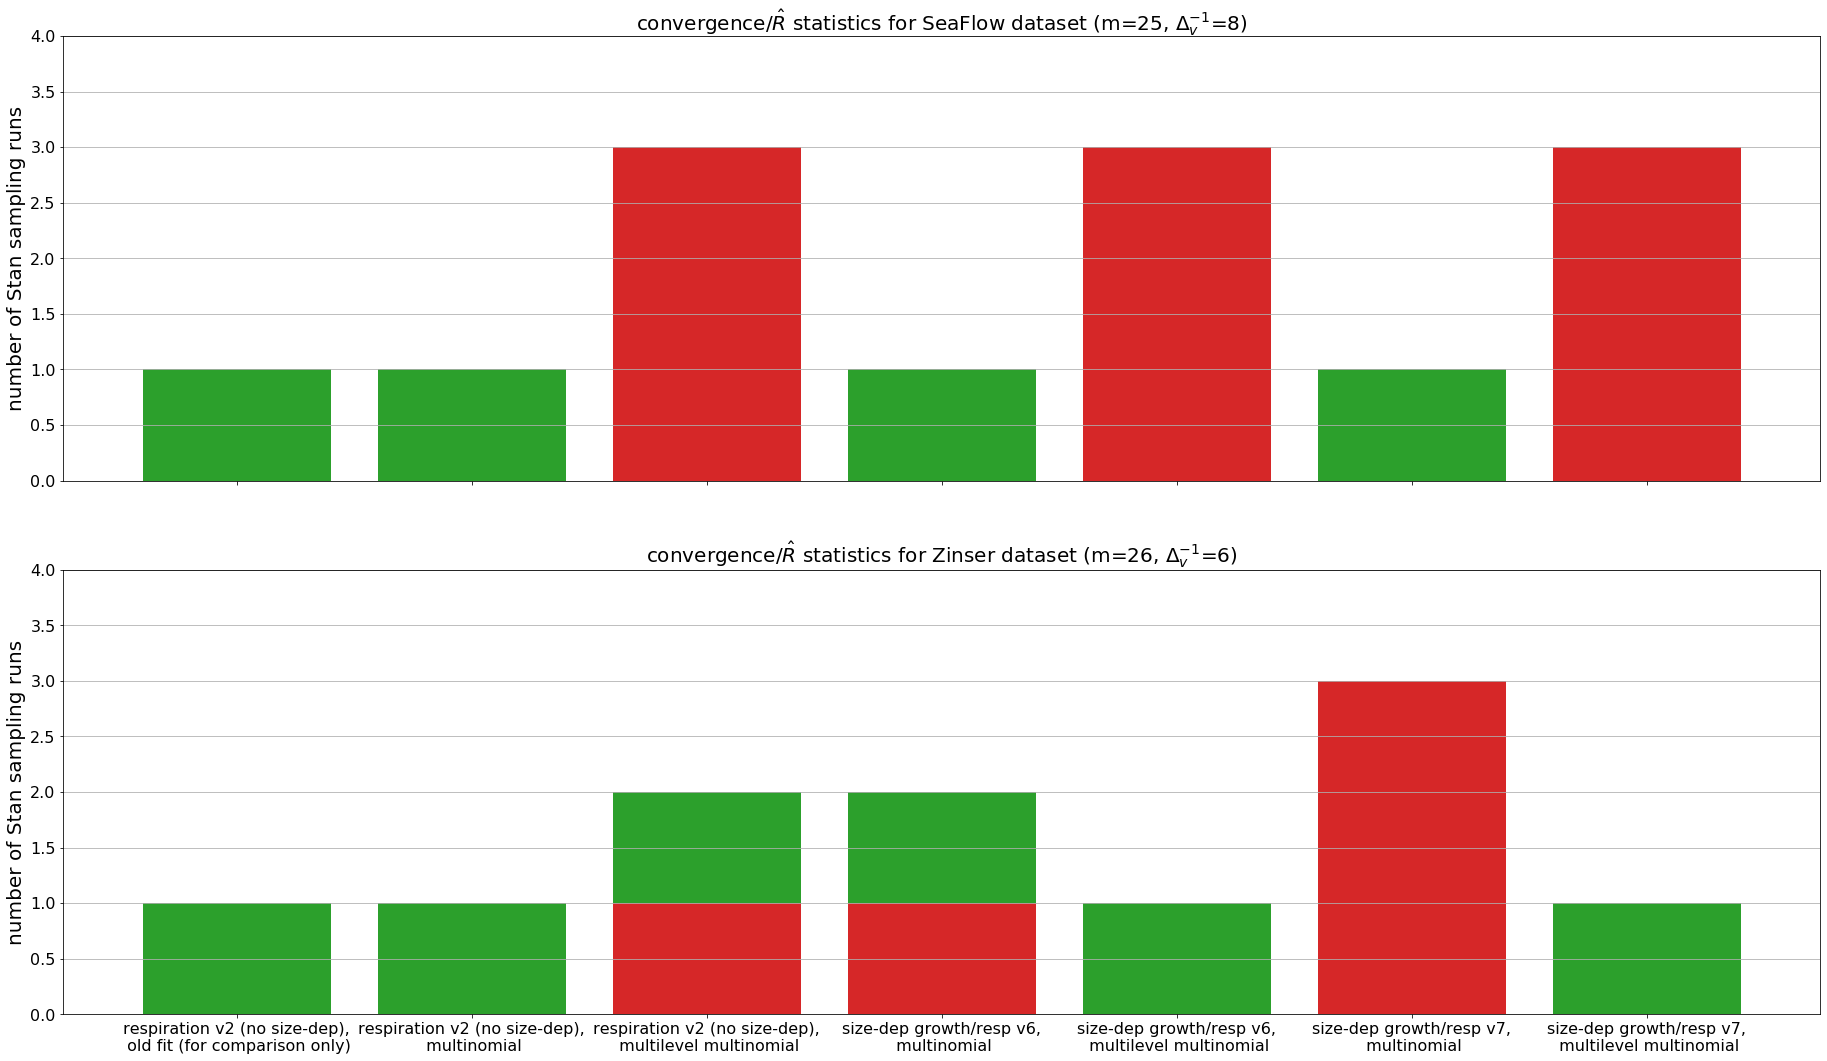

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

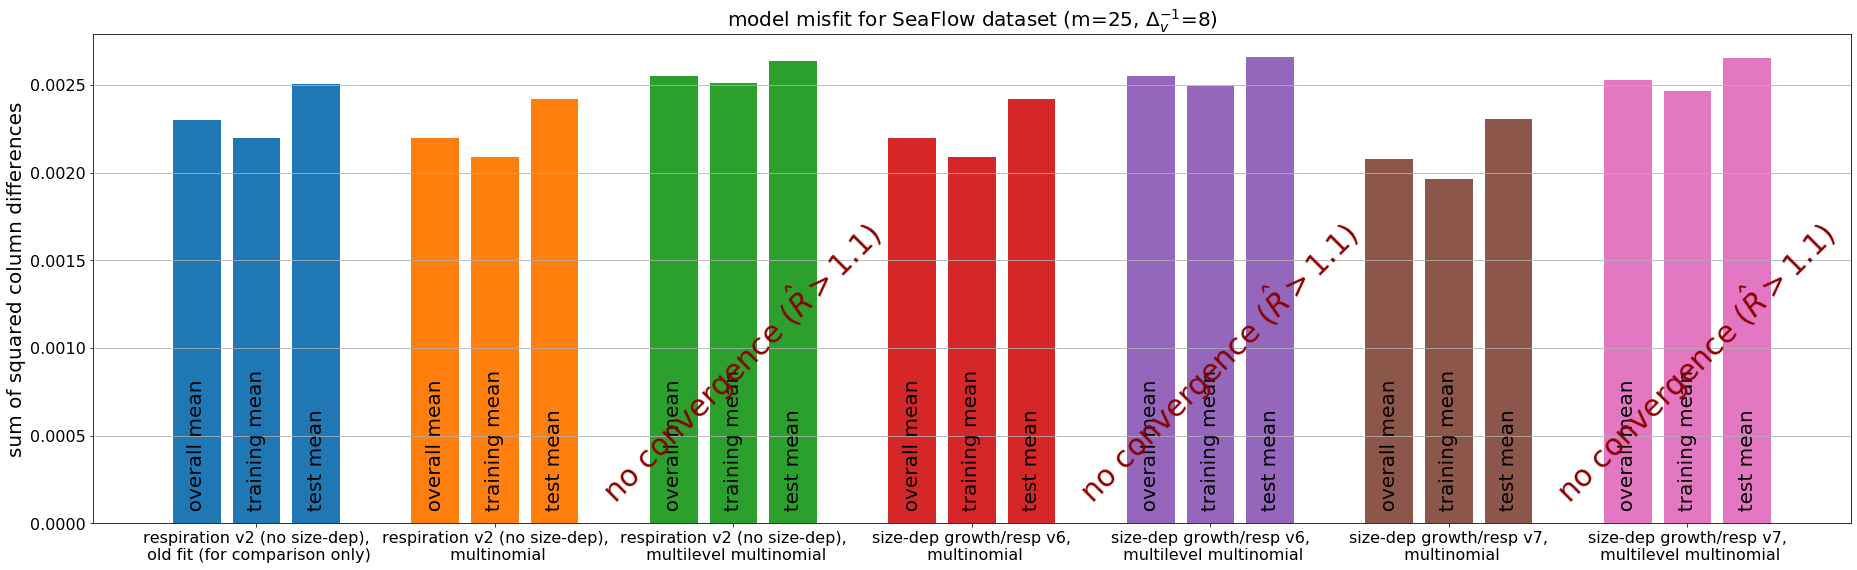

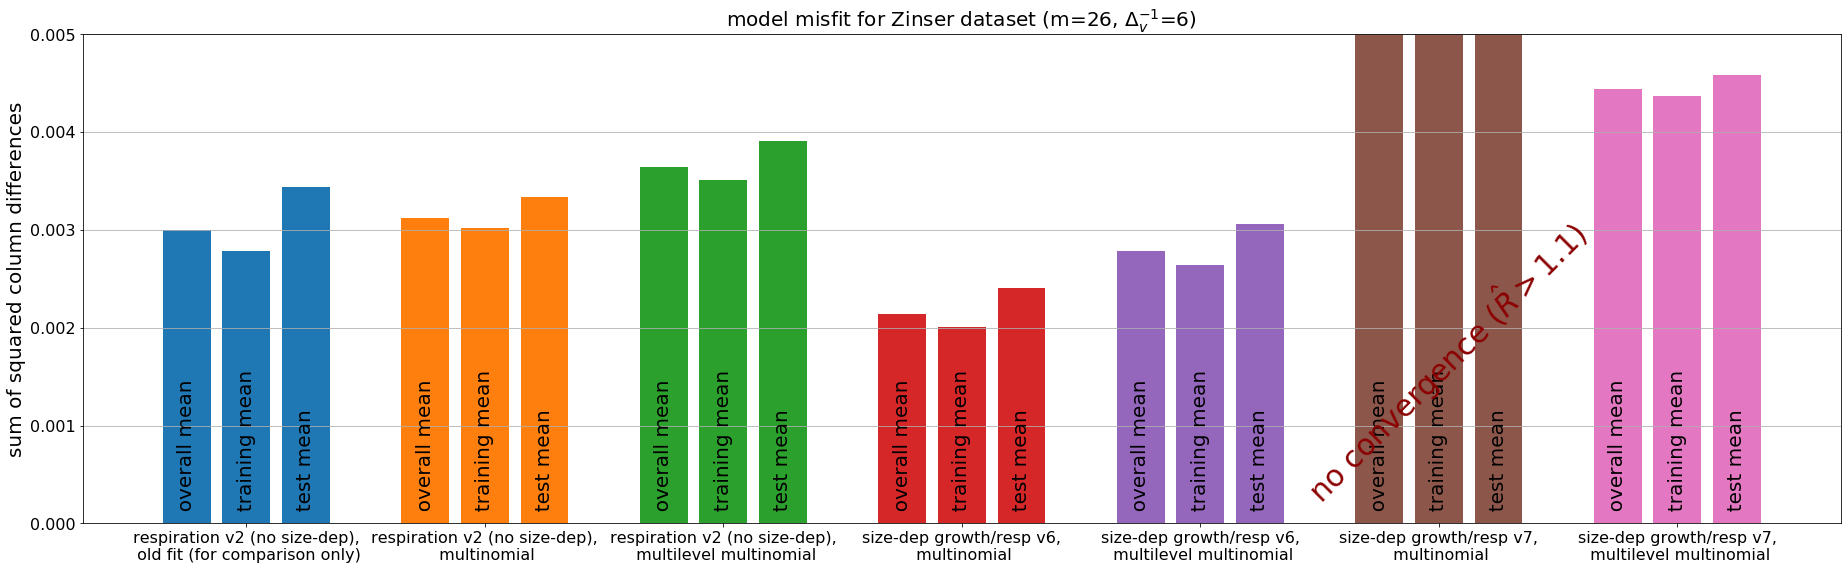

In [9]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

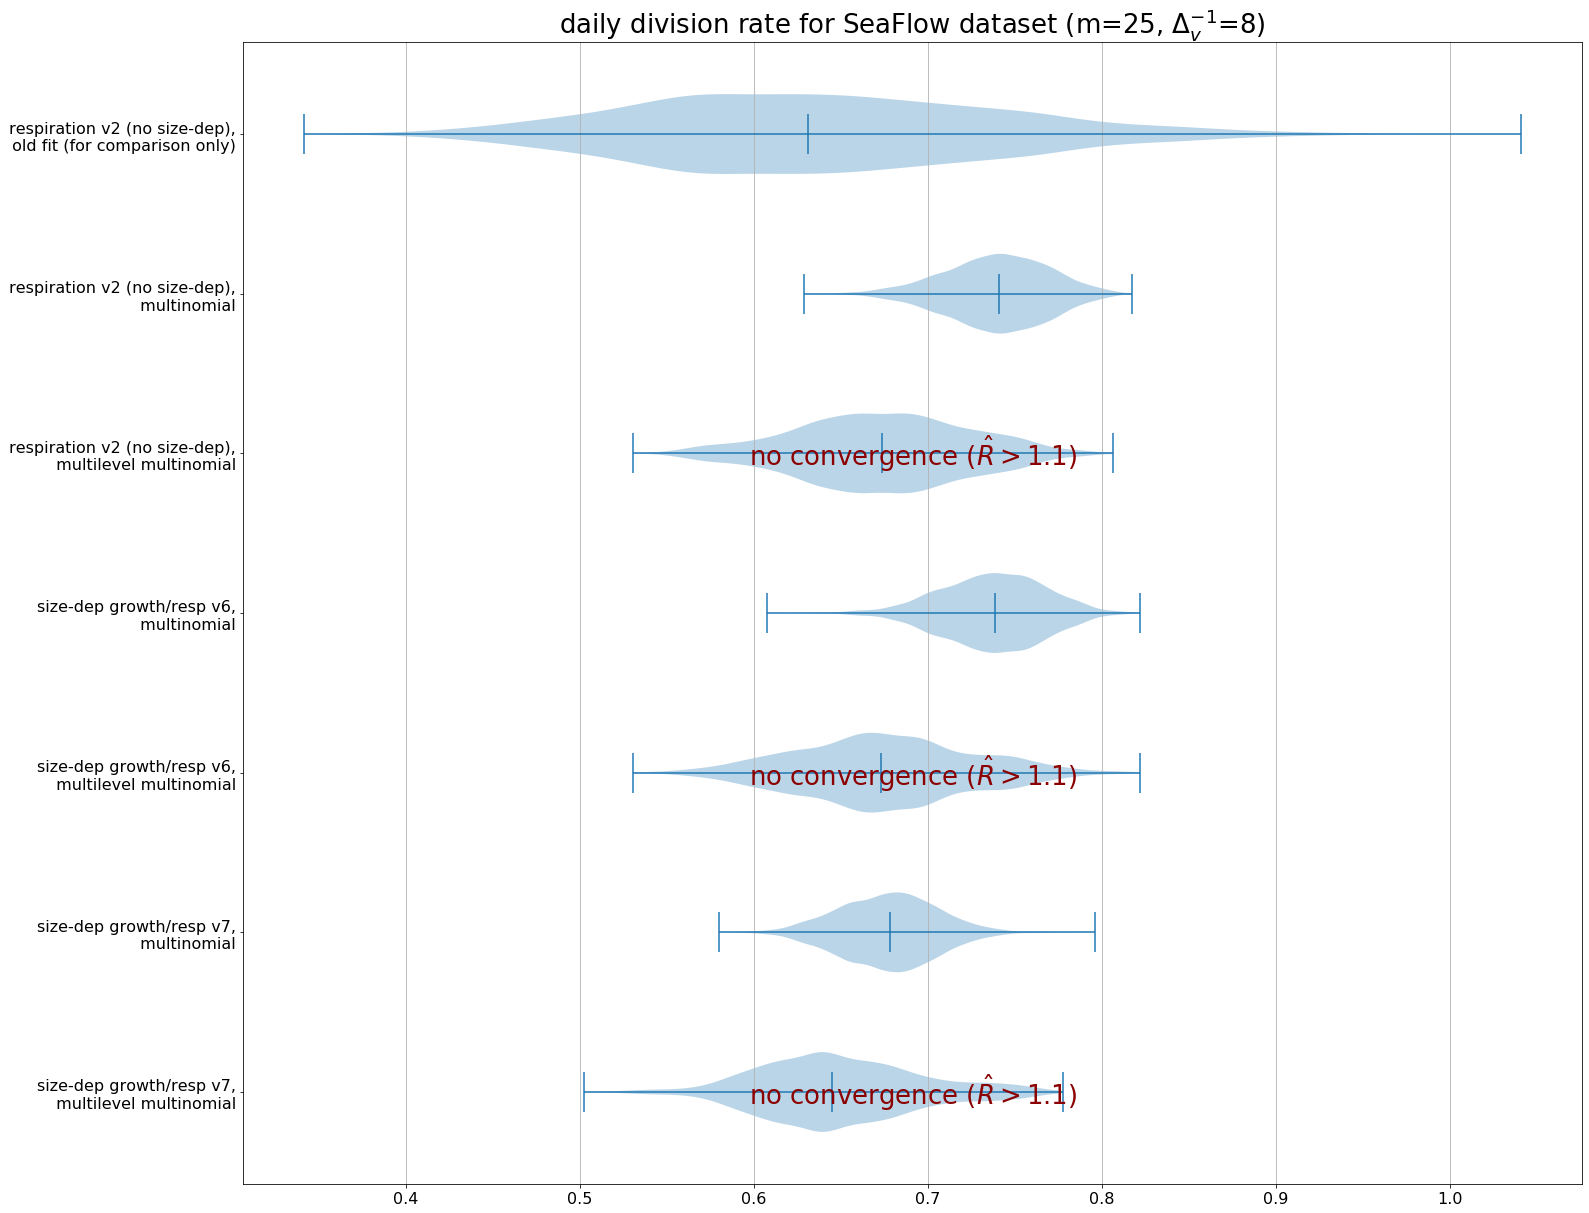

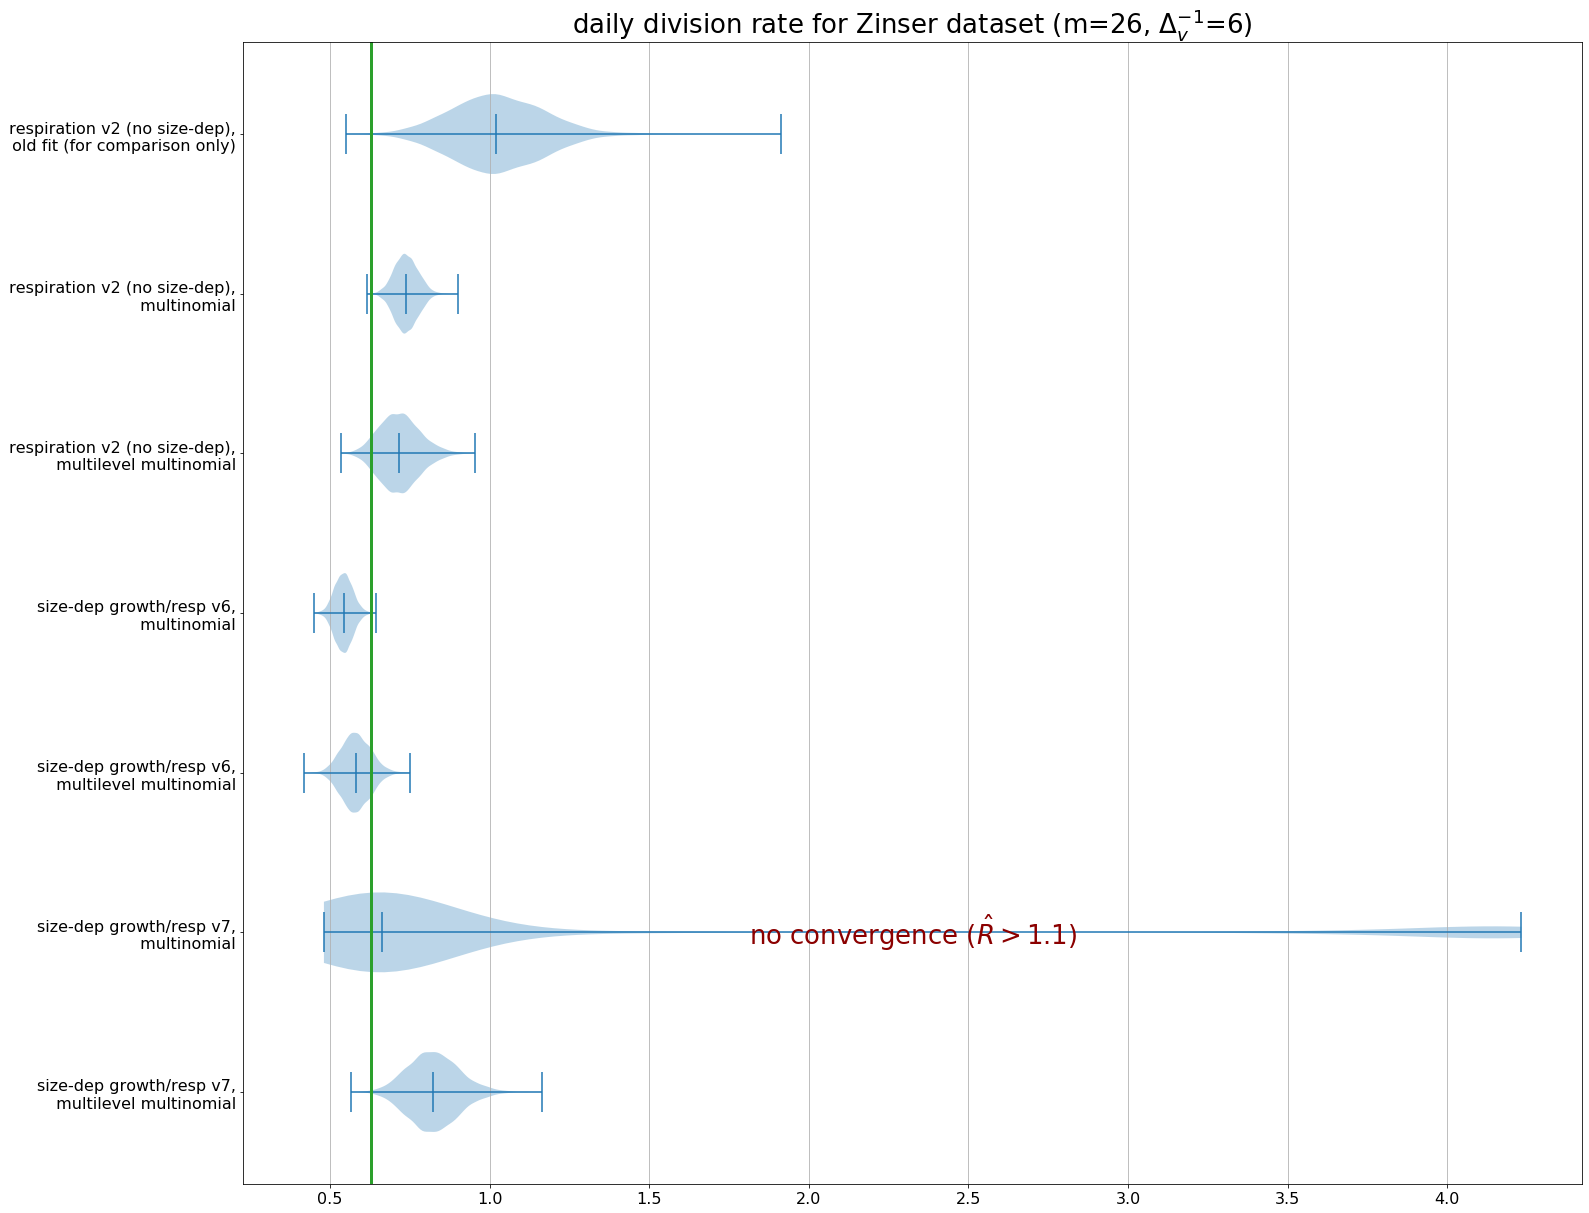

In [10]:
for dataname in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[dataname])
    ax.violinplot([mcmcs[name][dataname]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in dataname:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

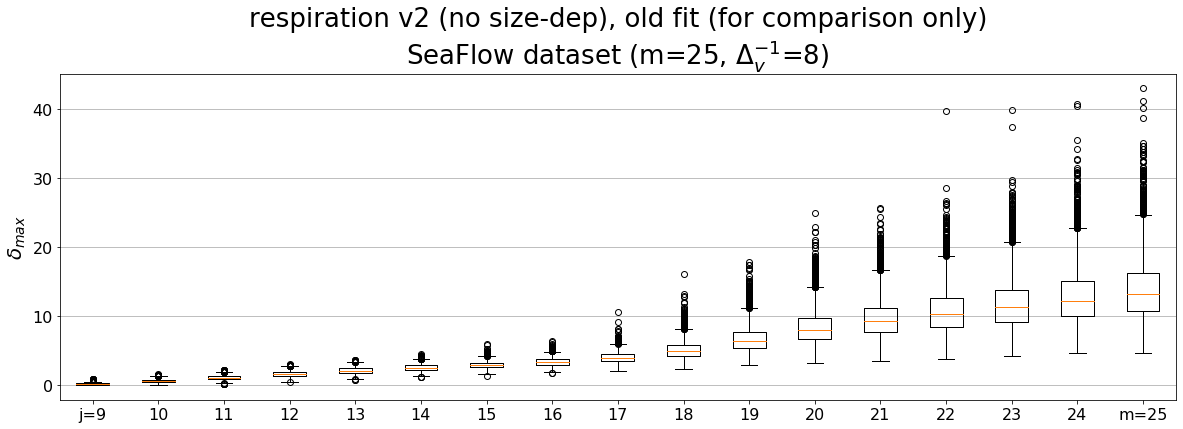

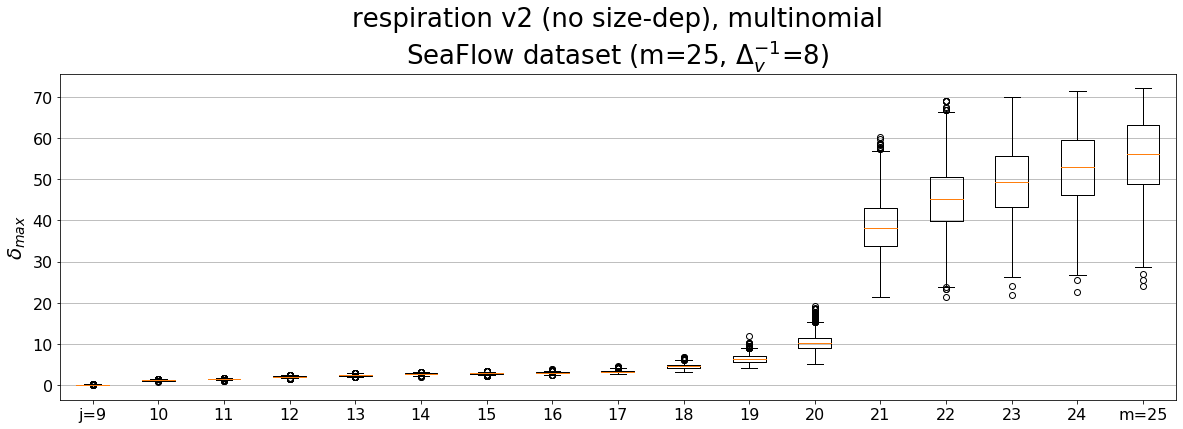

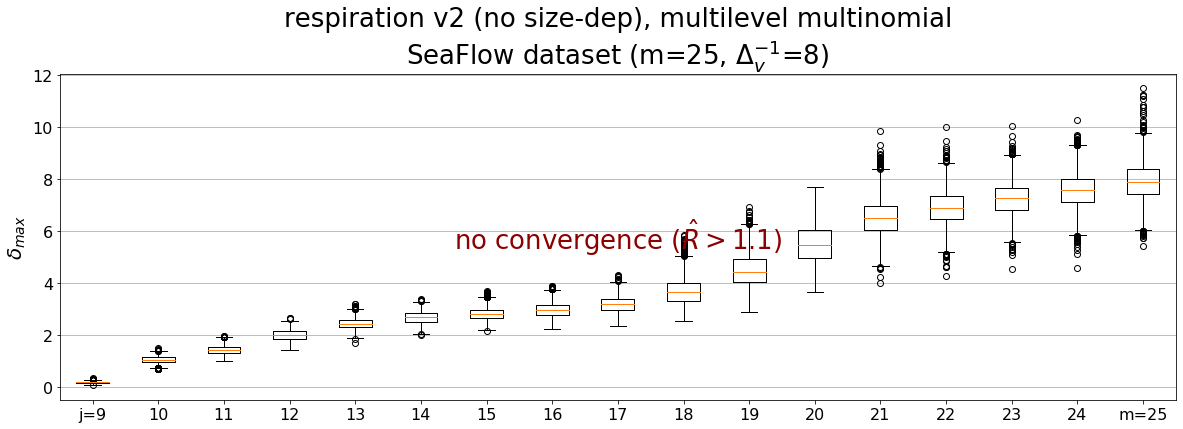

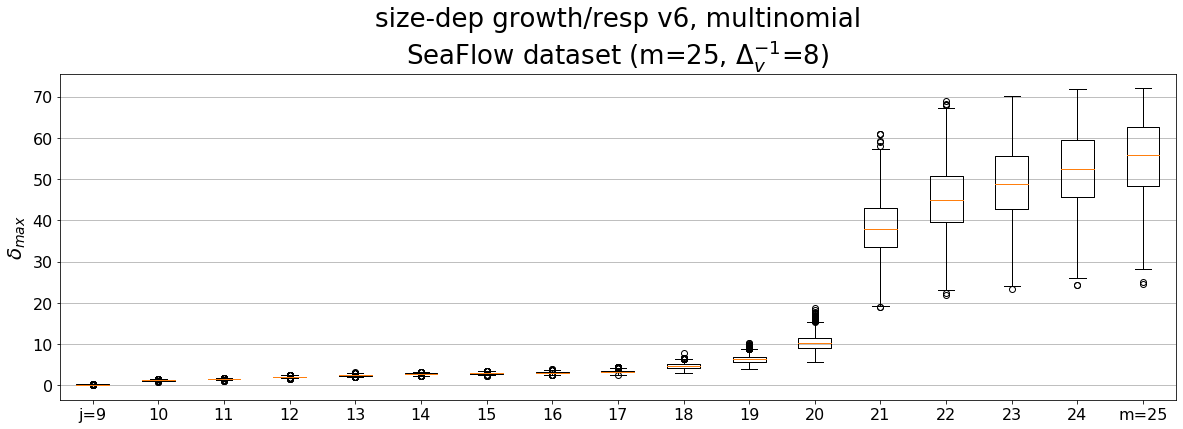

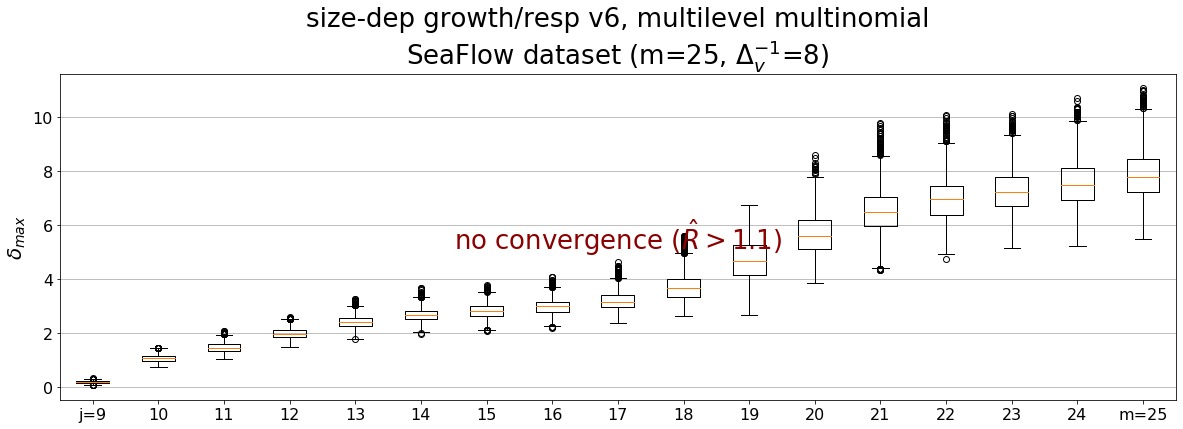

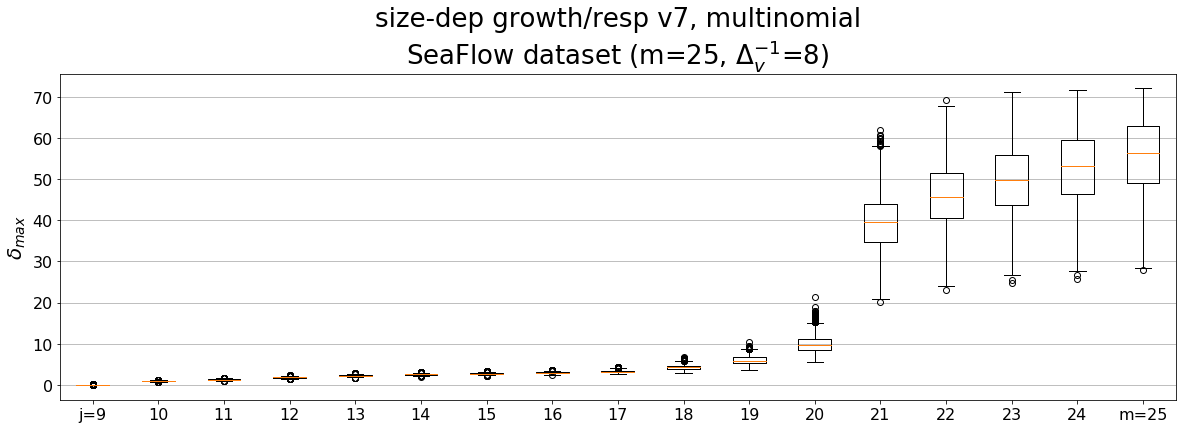

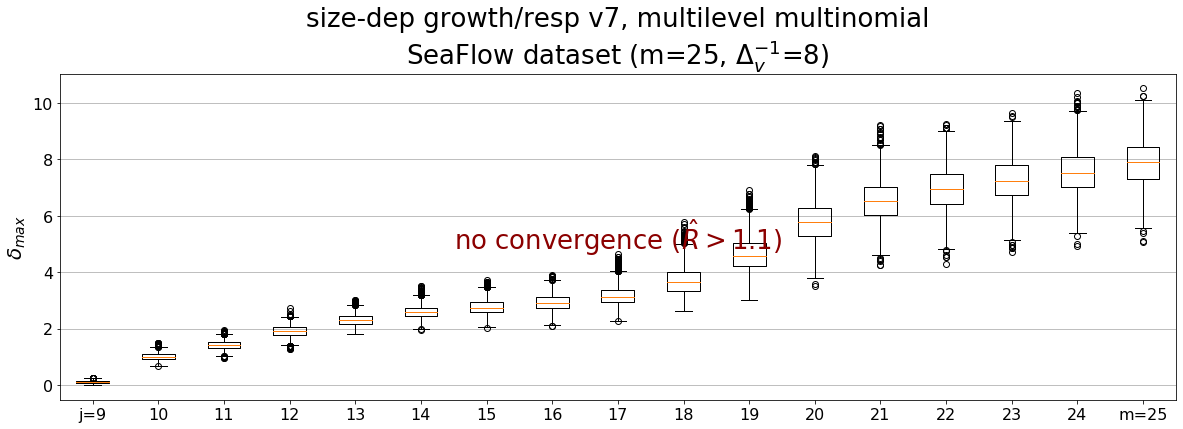

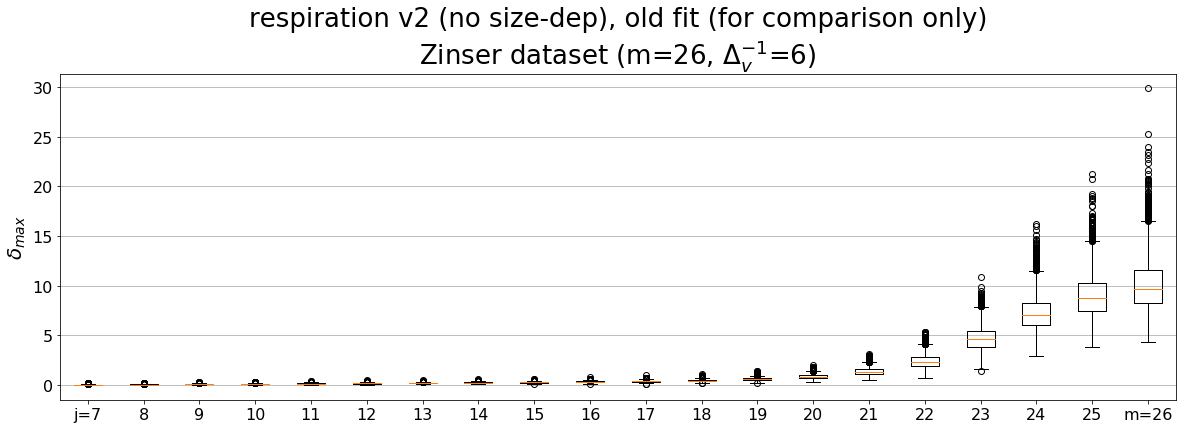

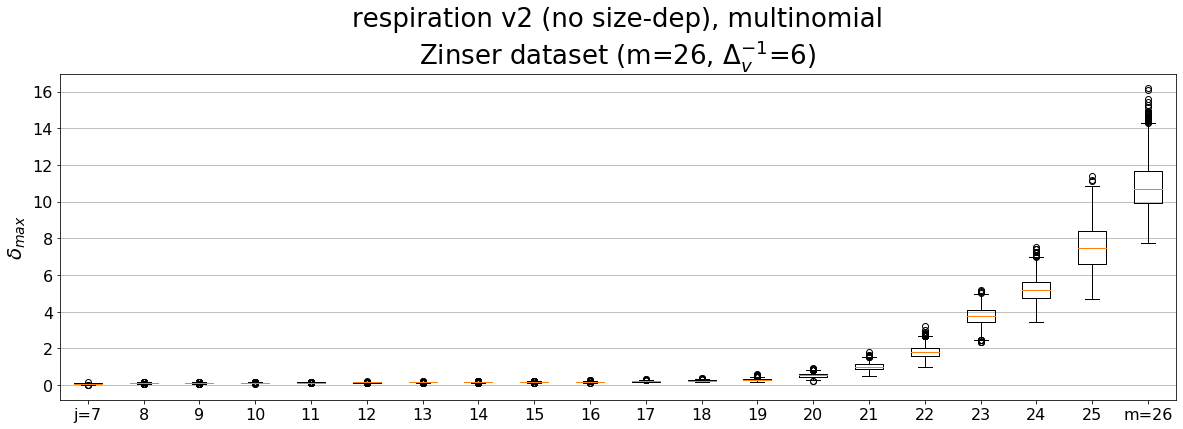

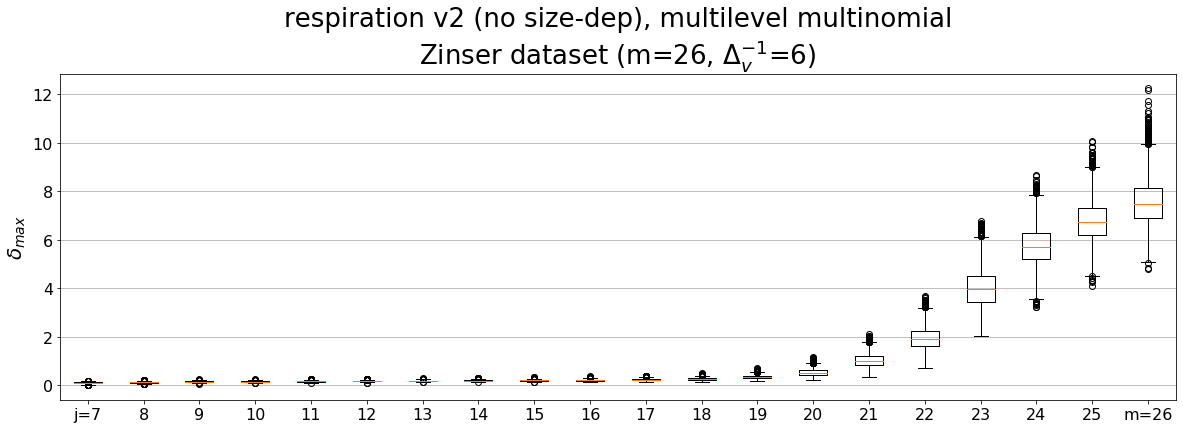

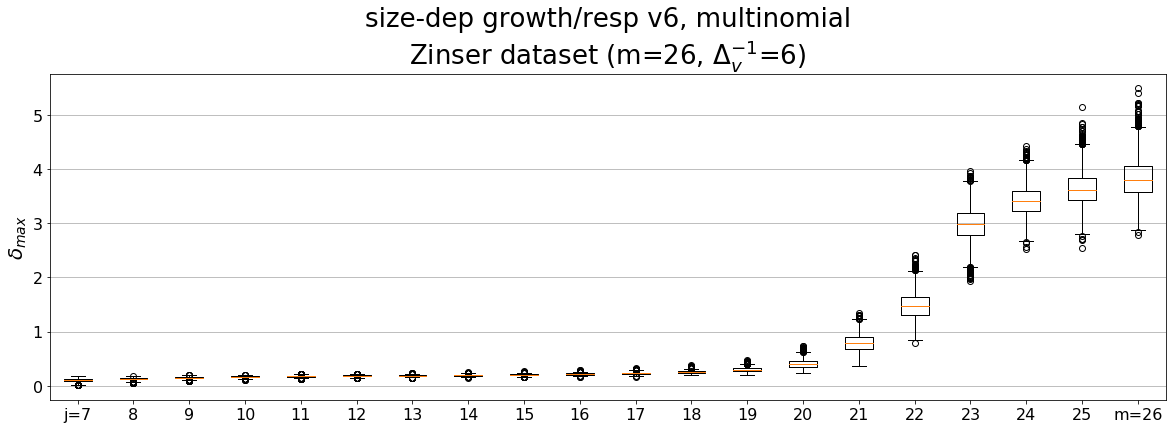

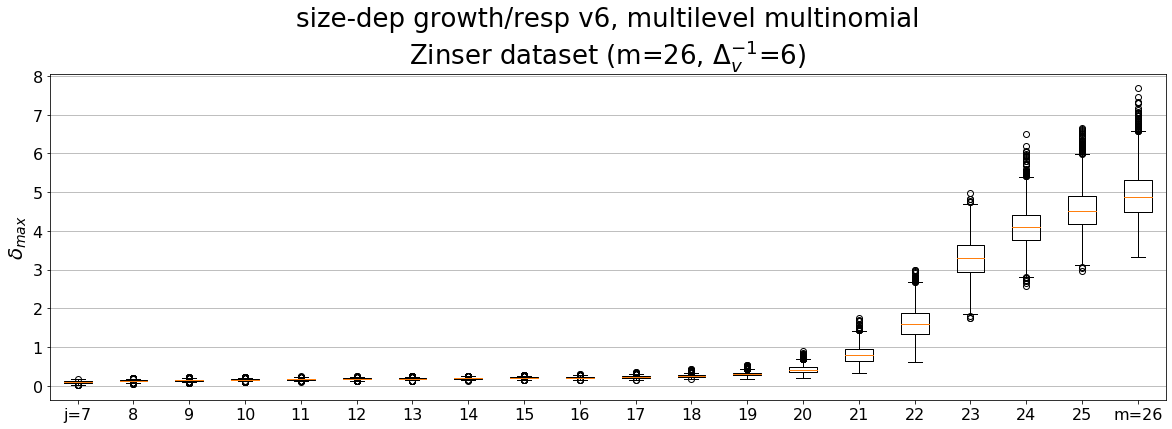

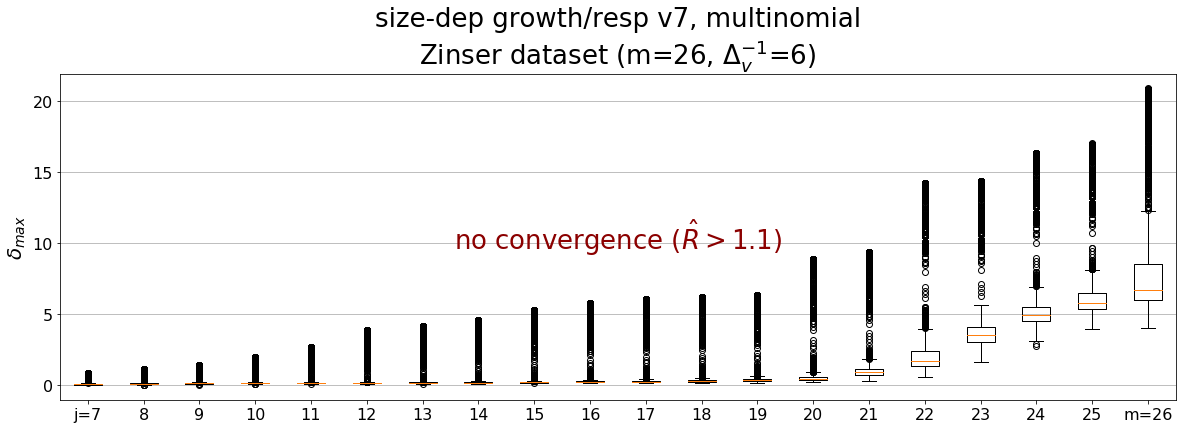

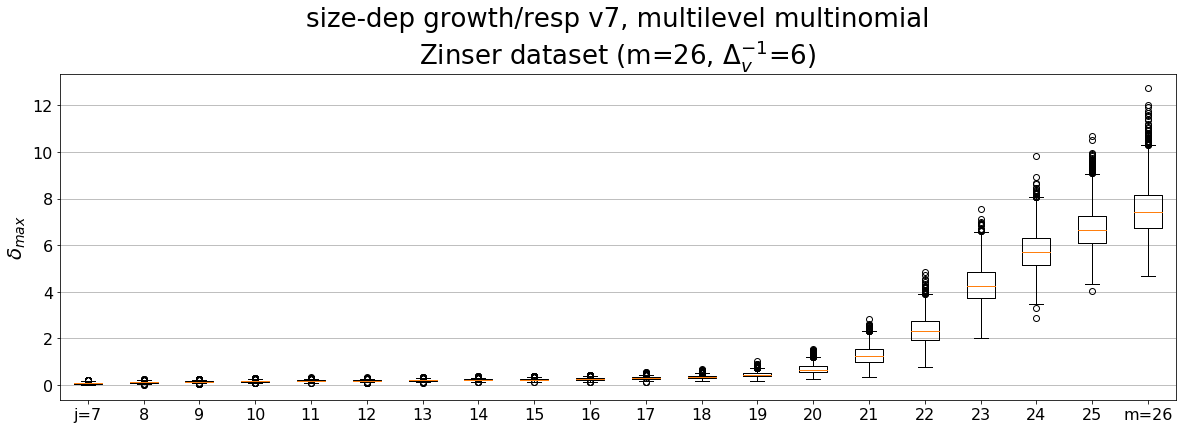

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

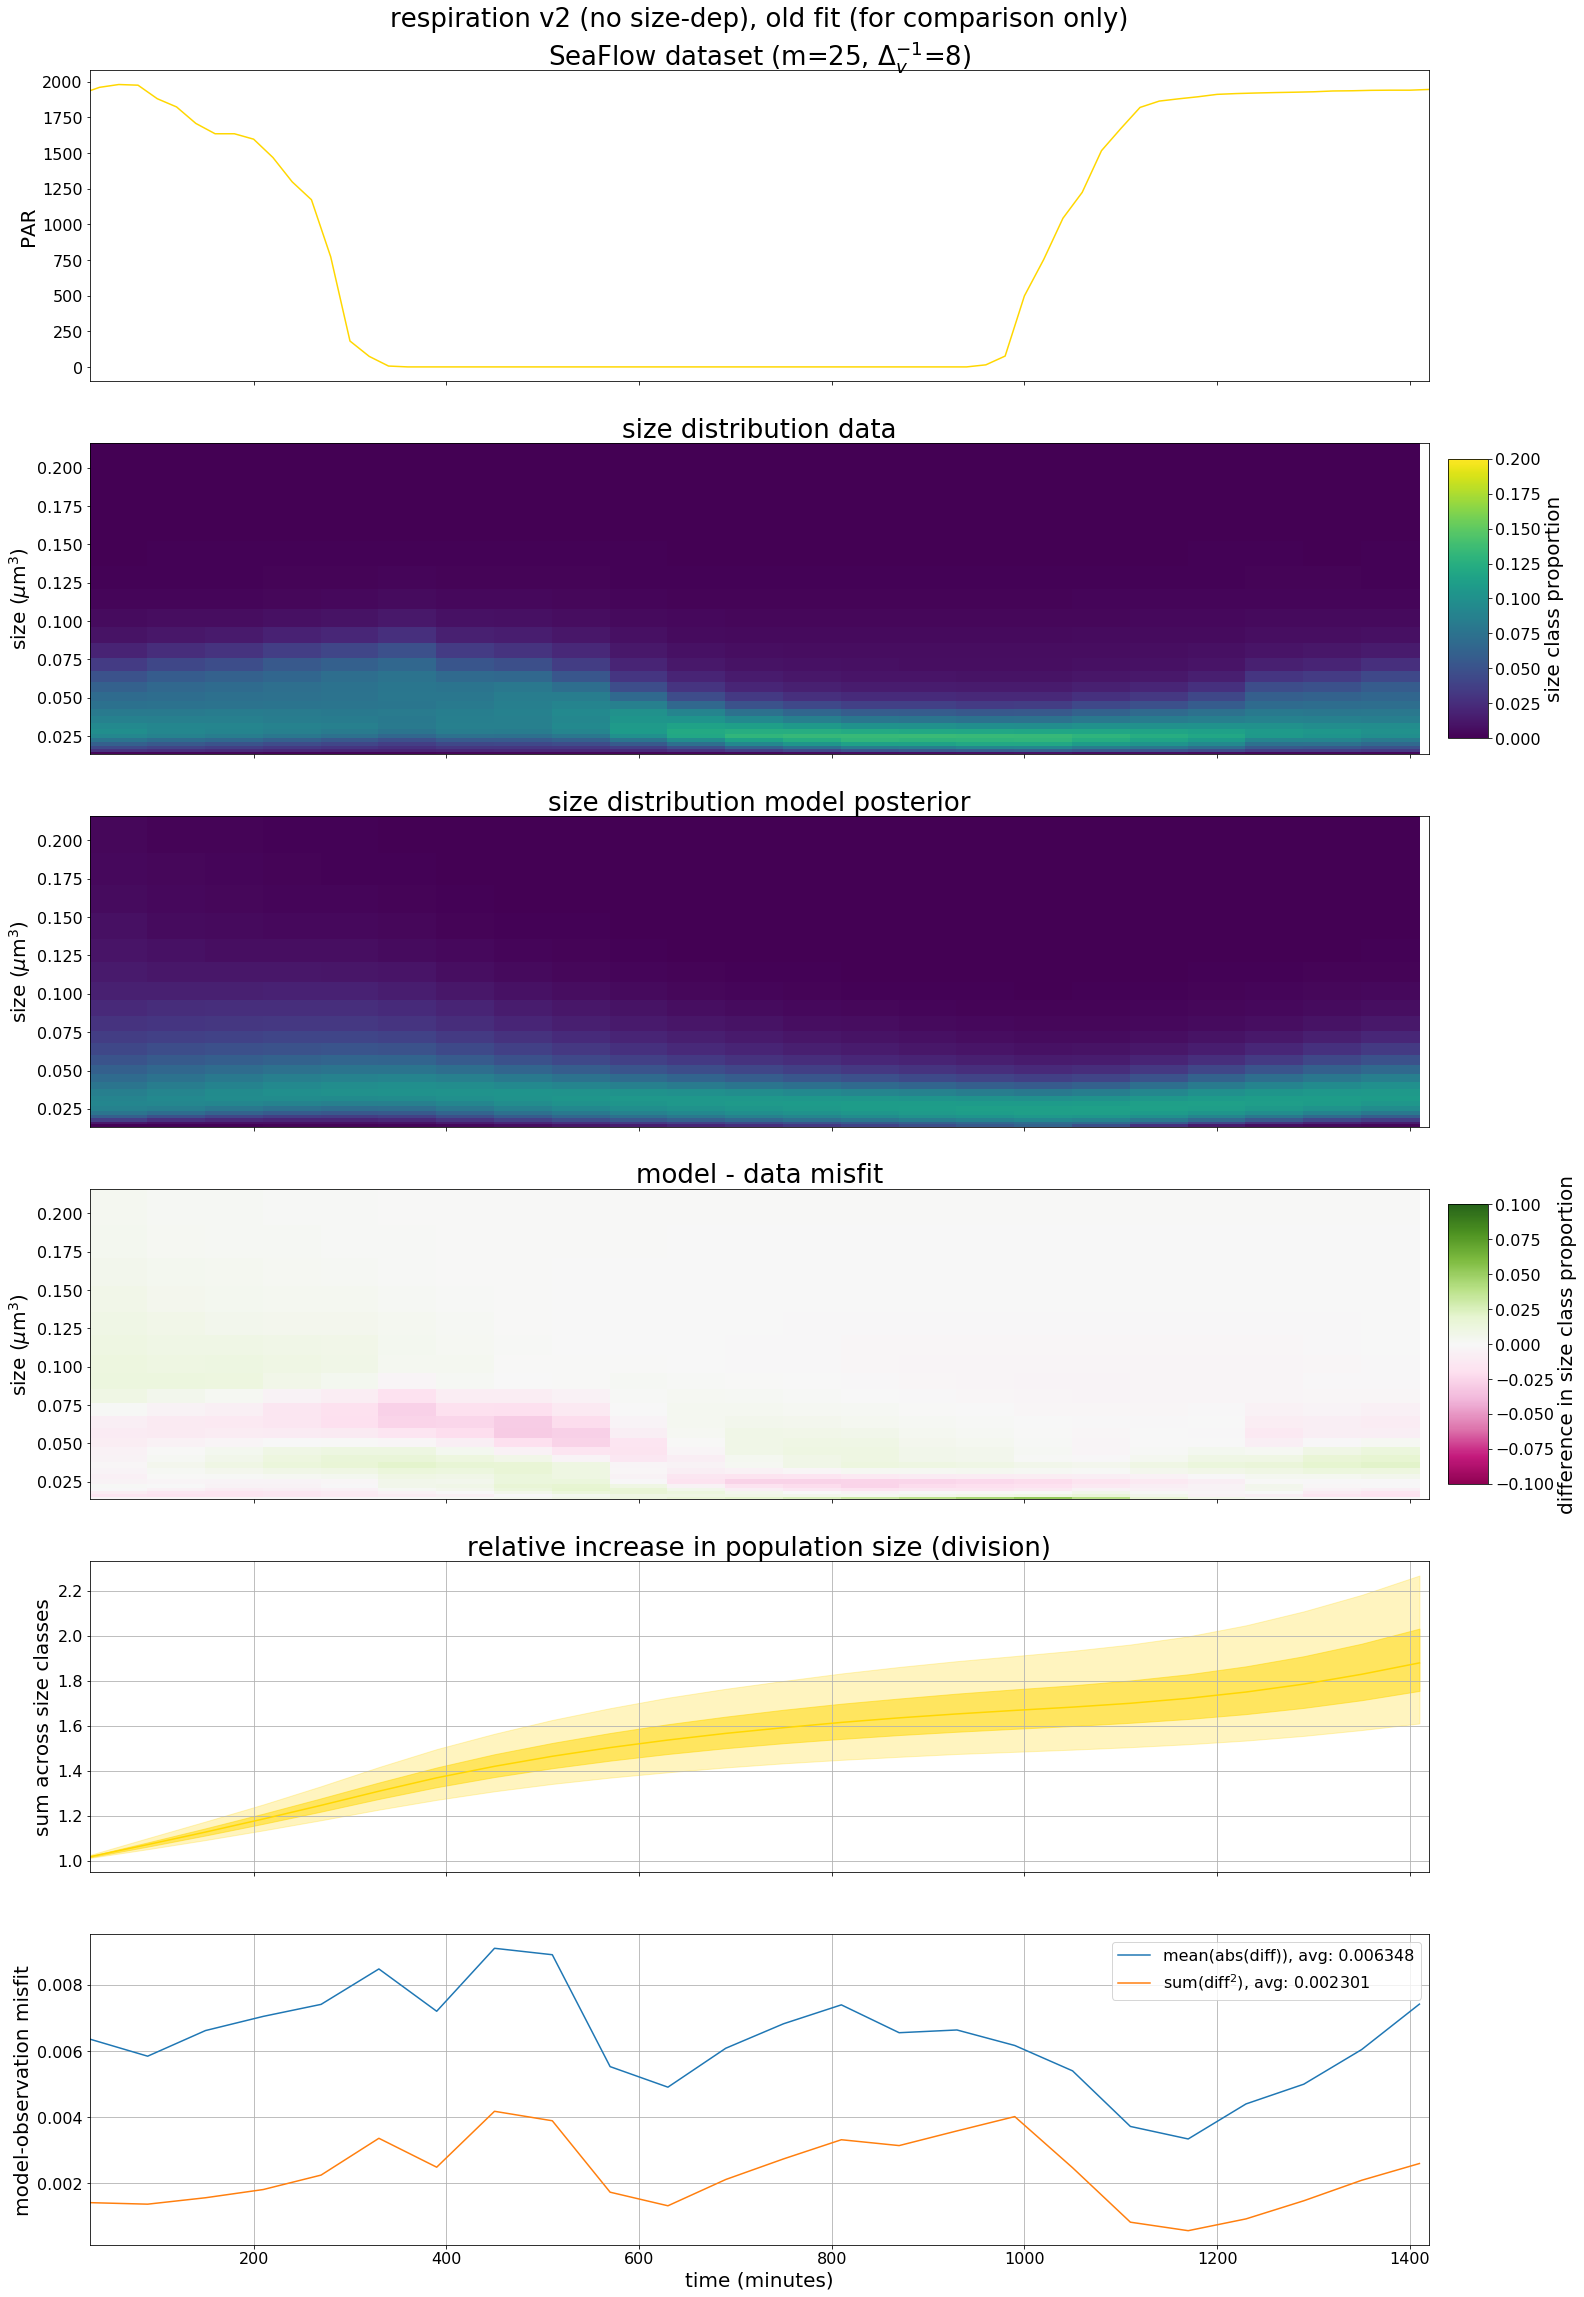

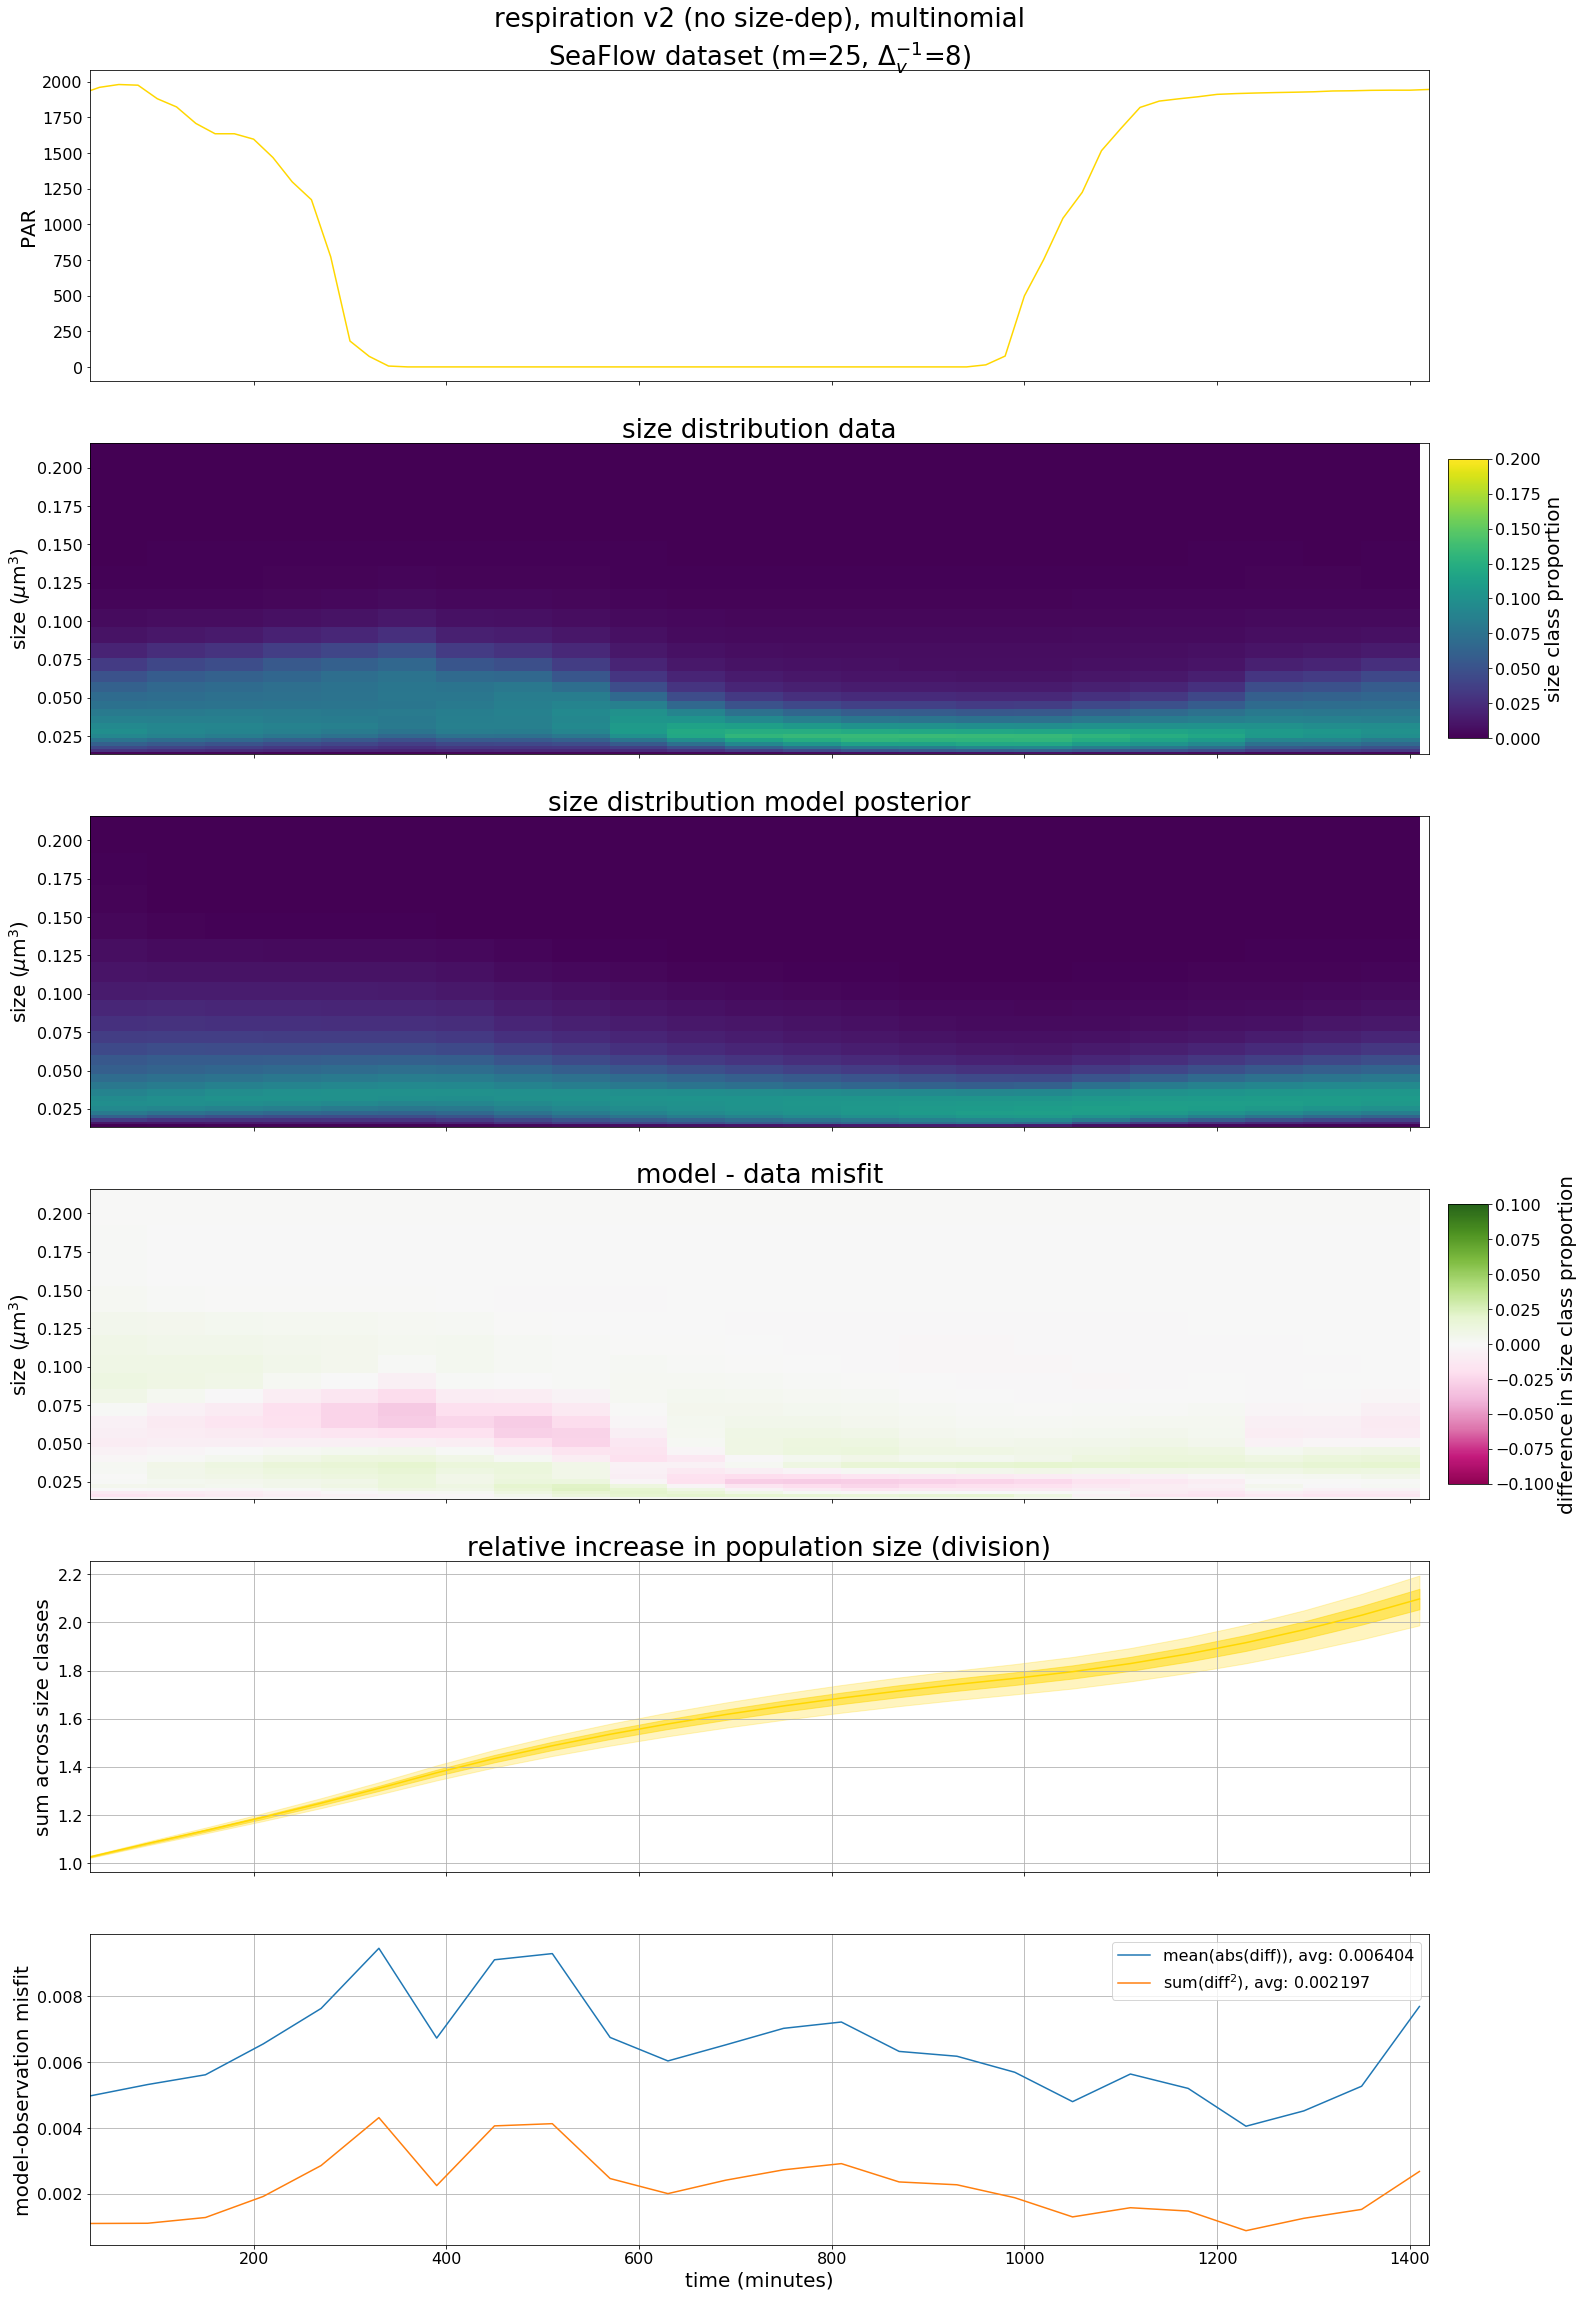

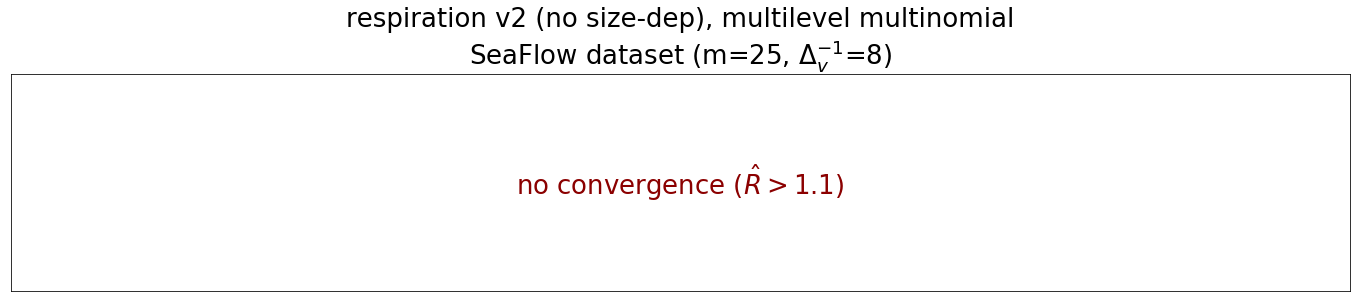

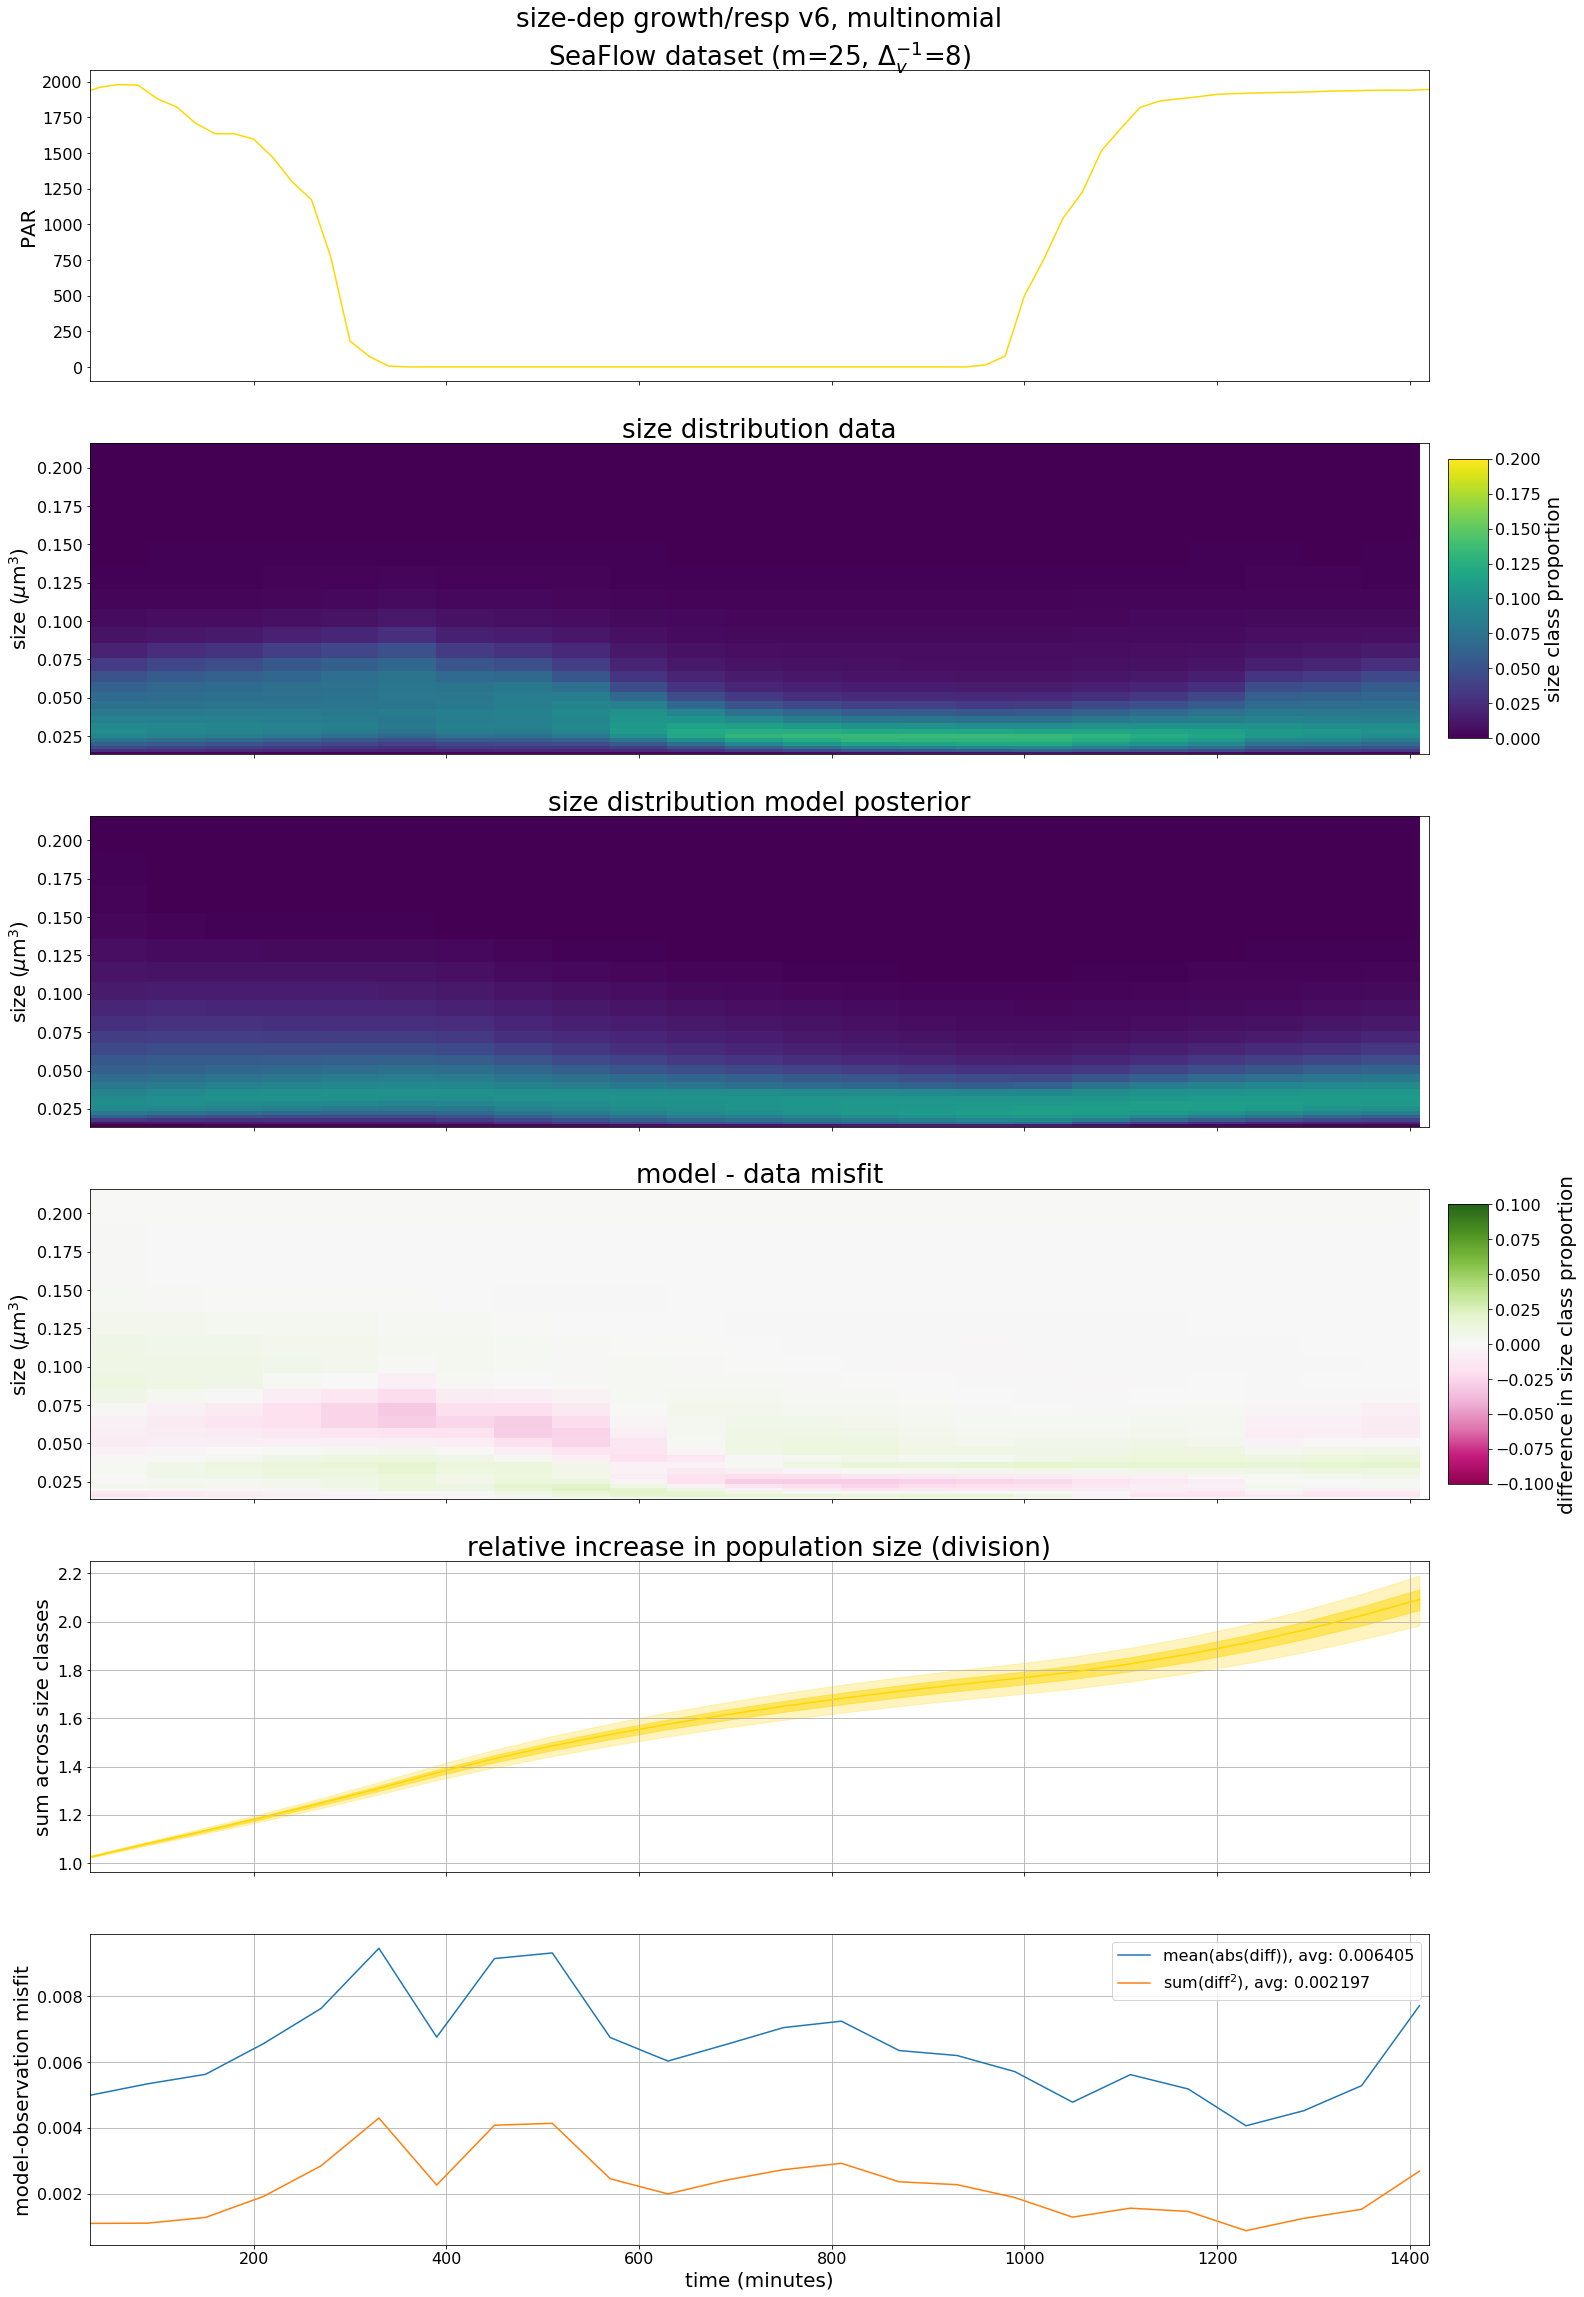

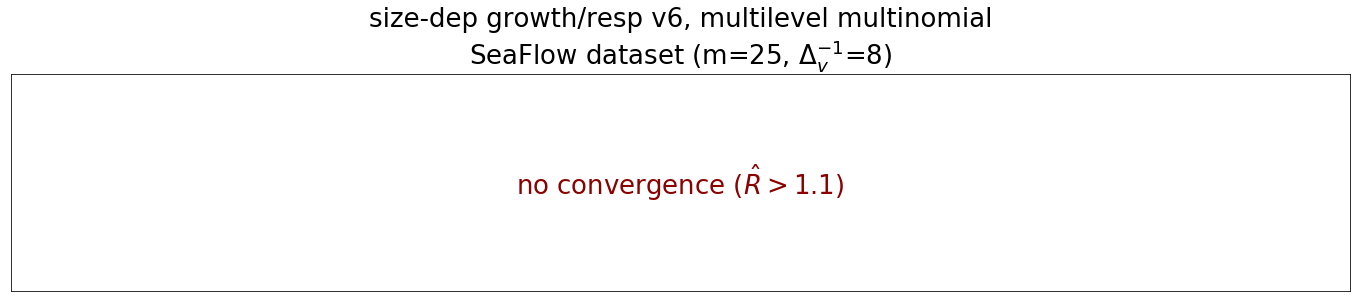

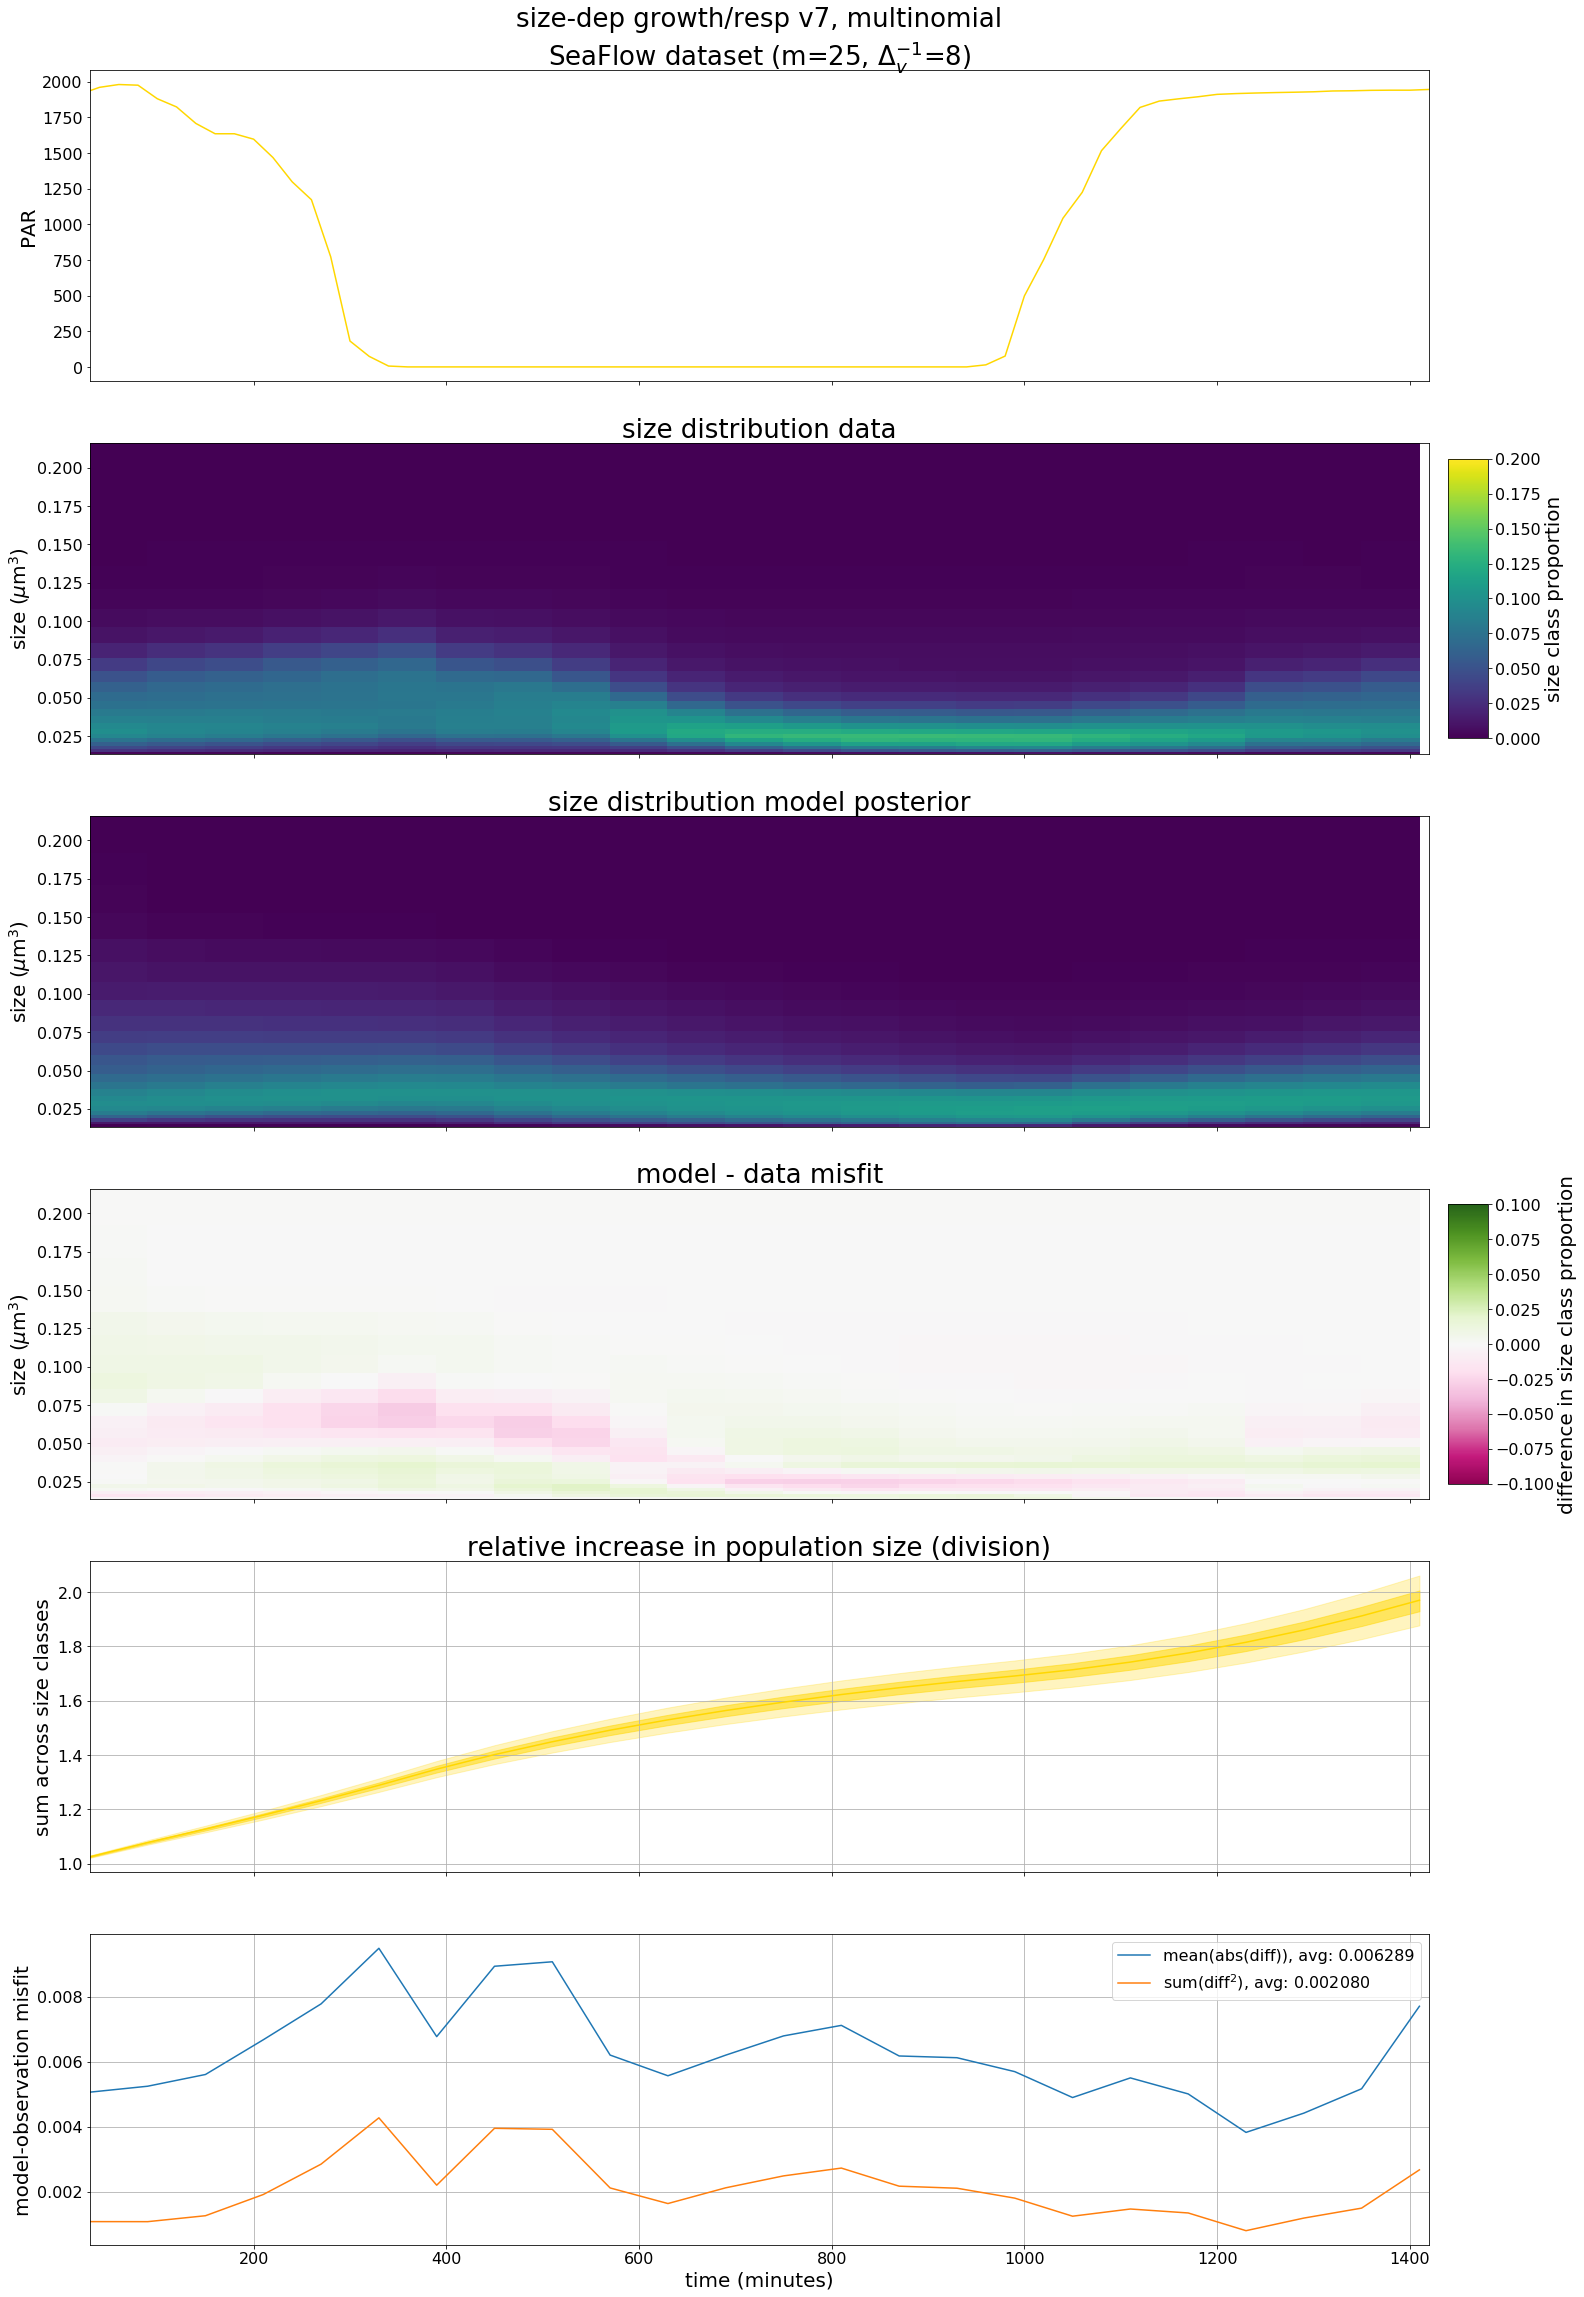

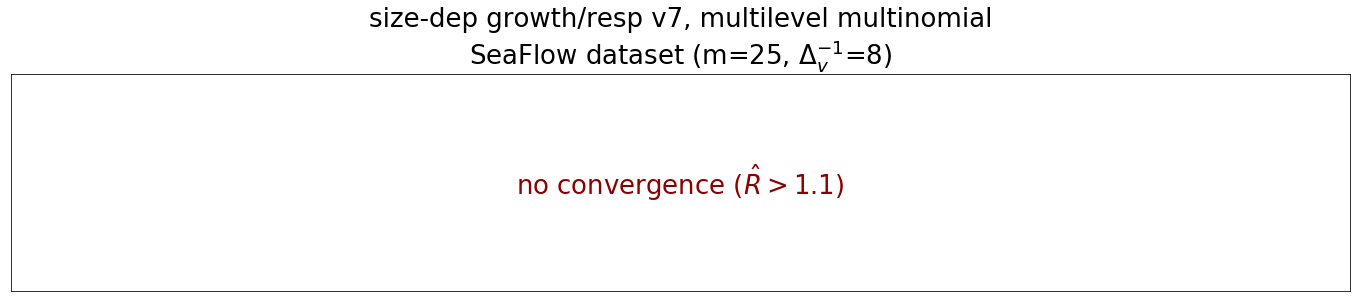

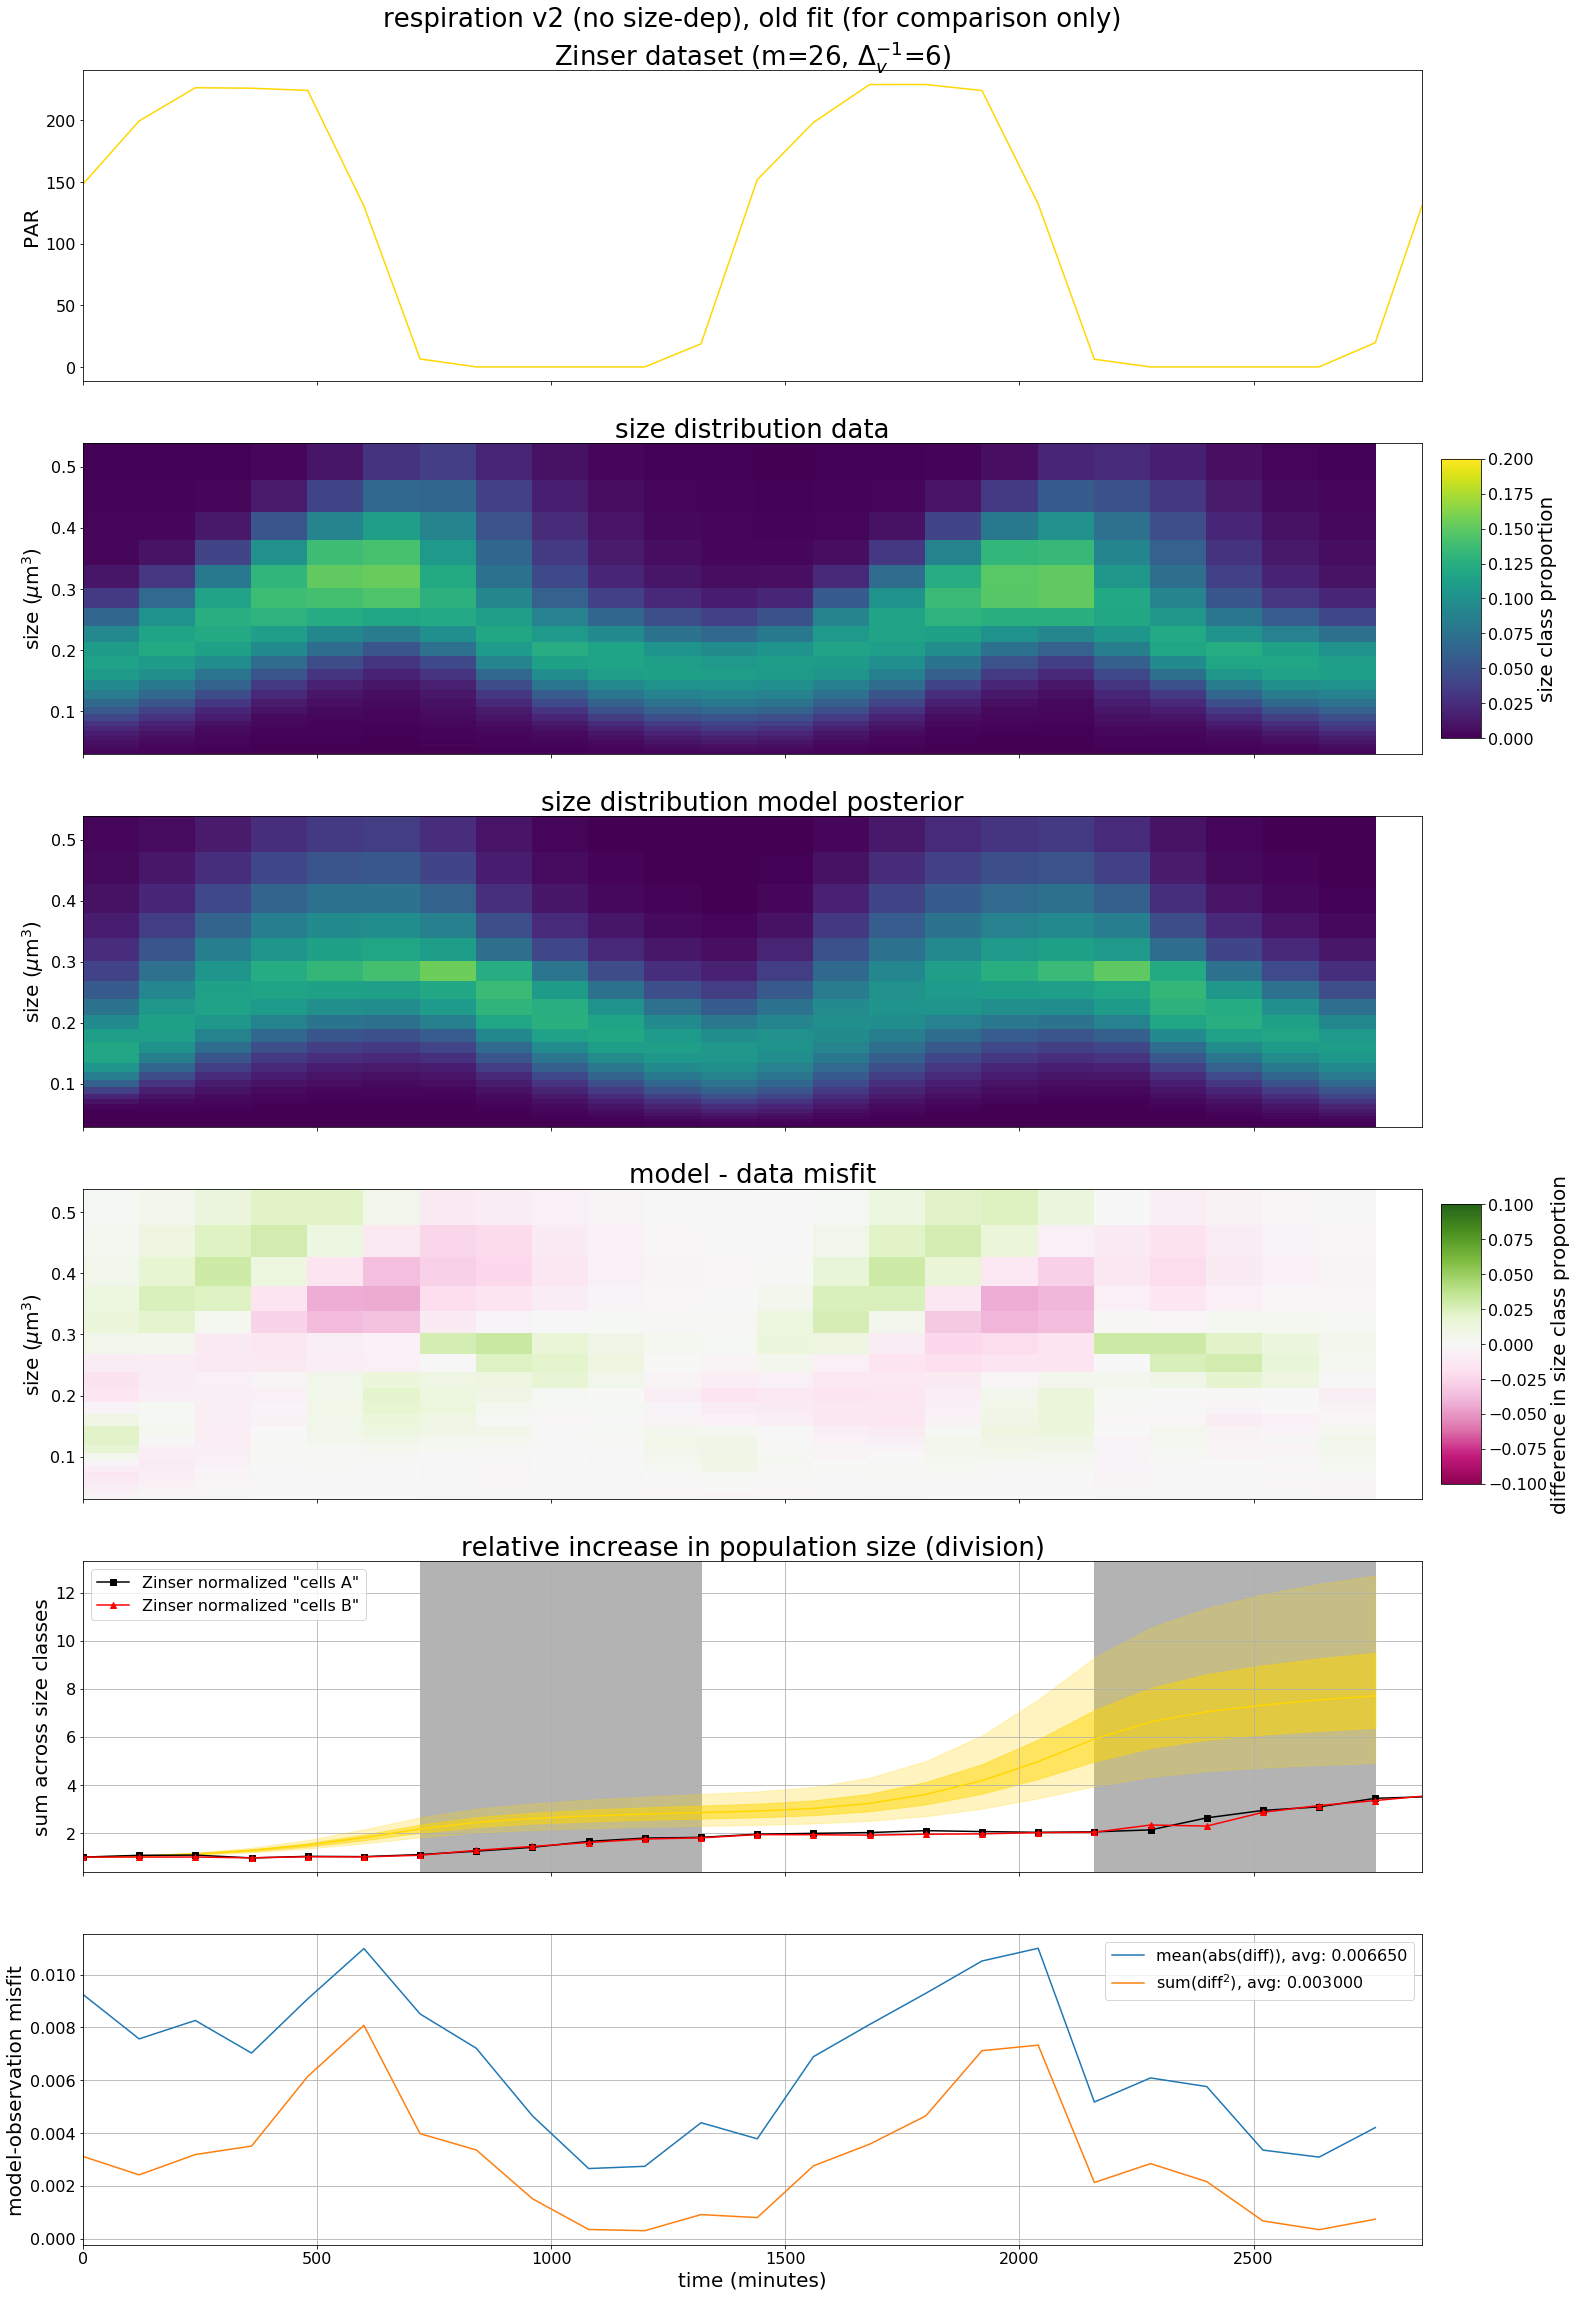

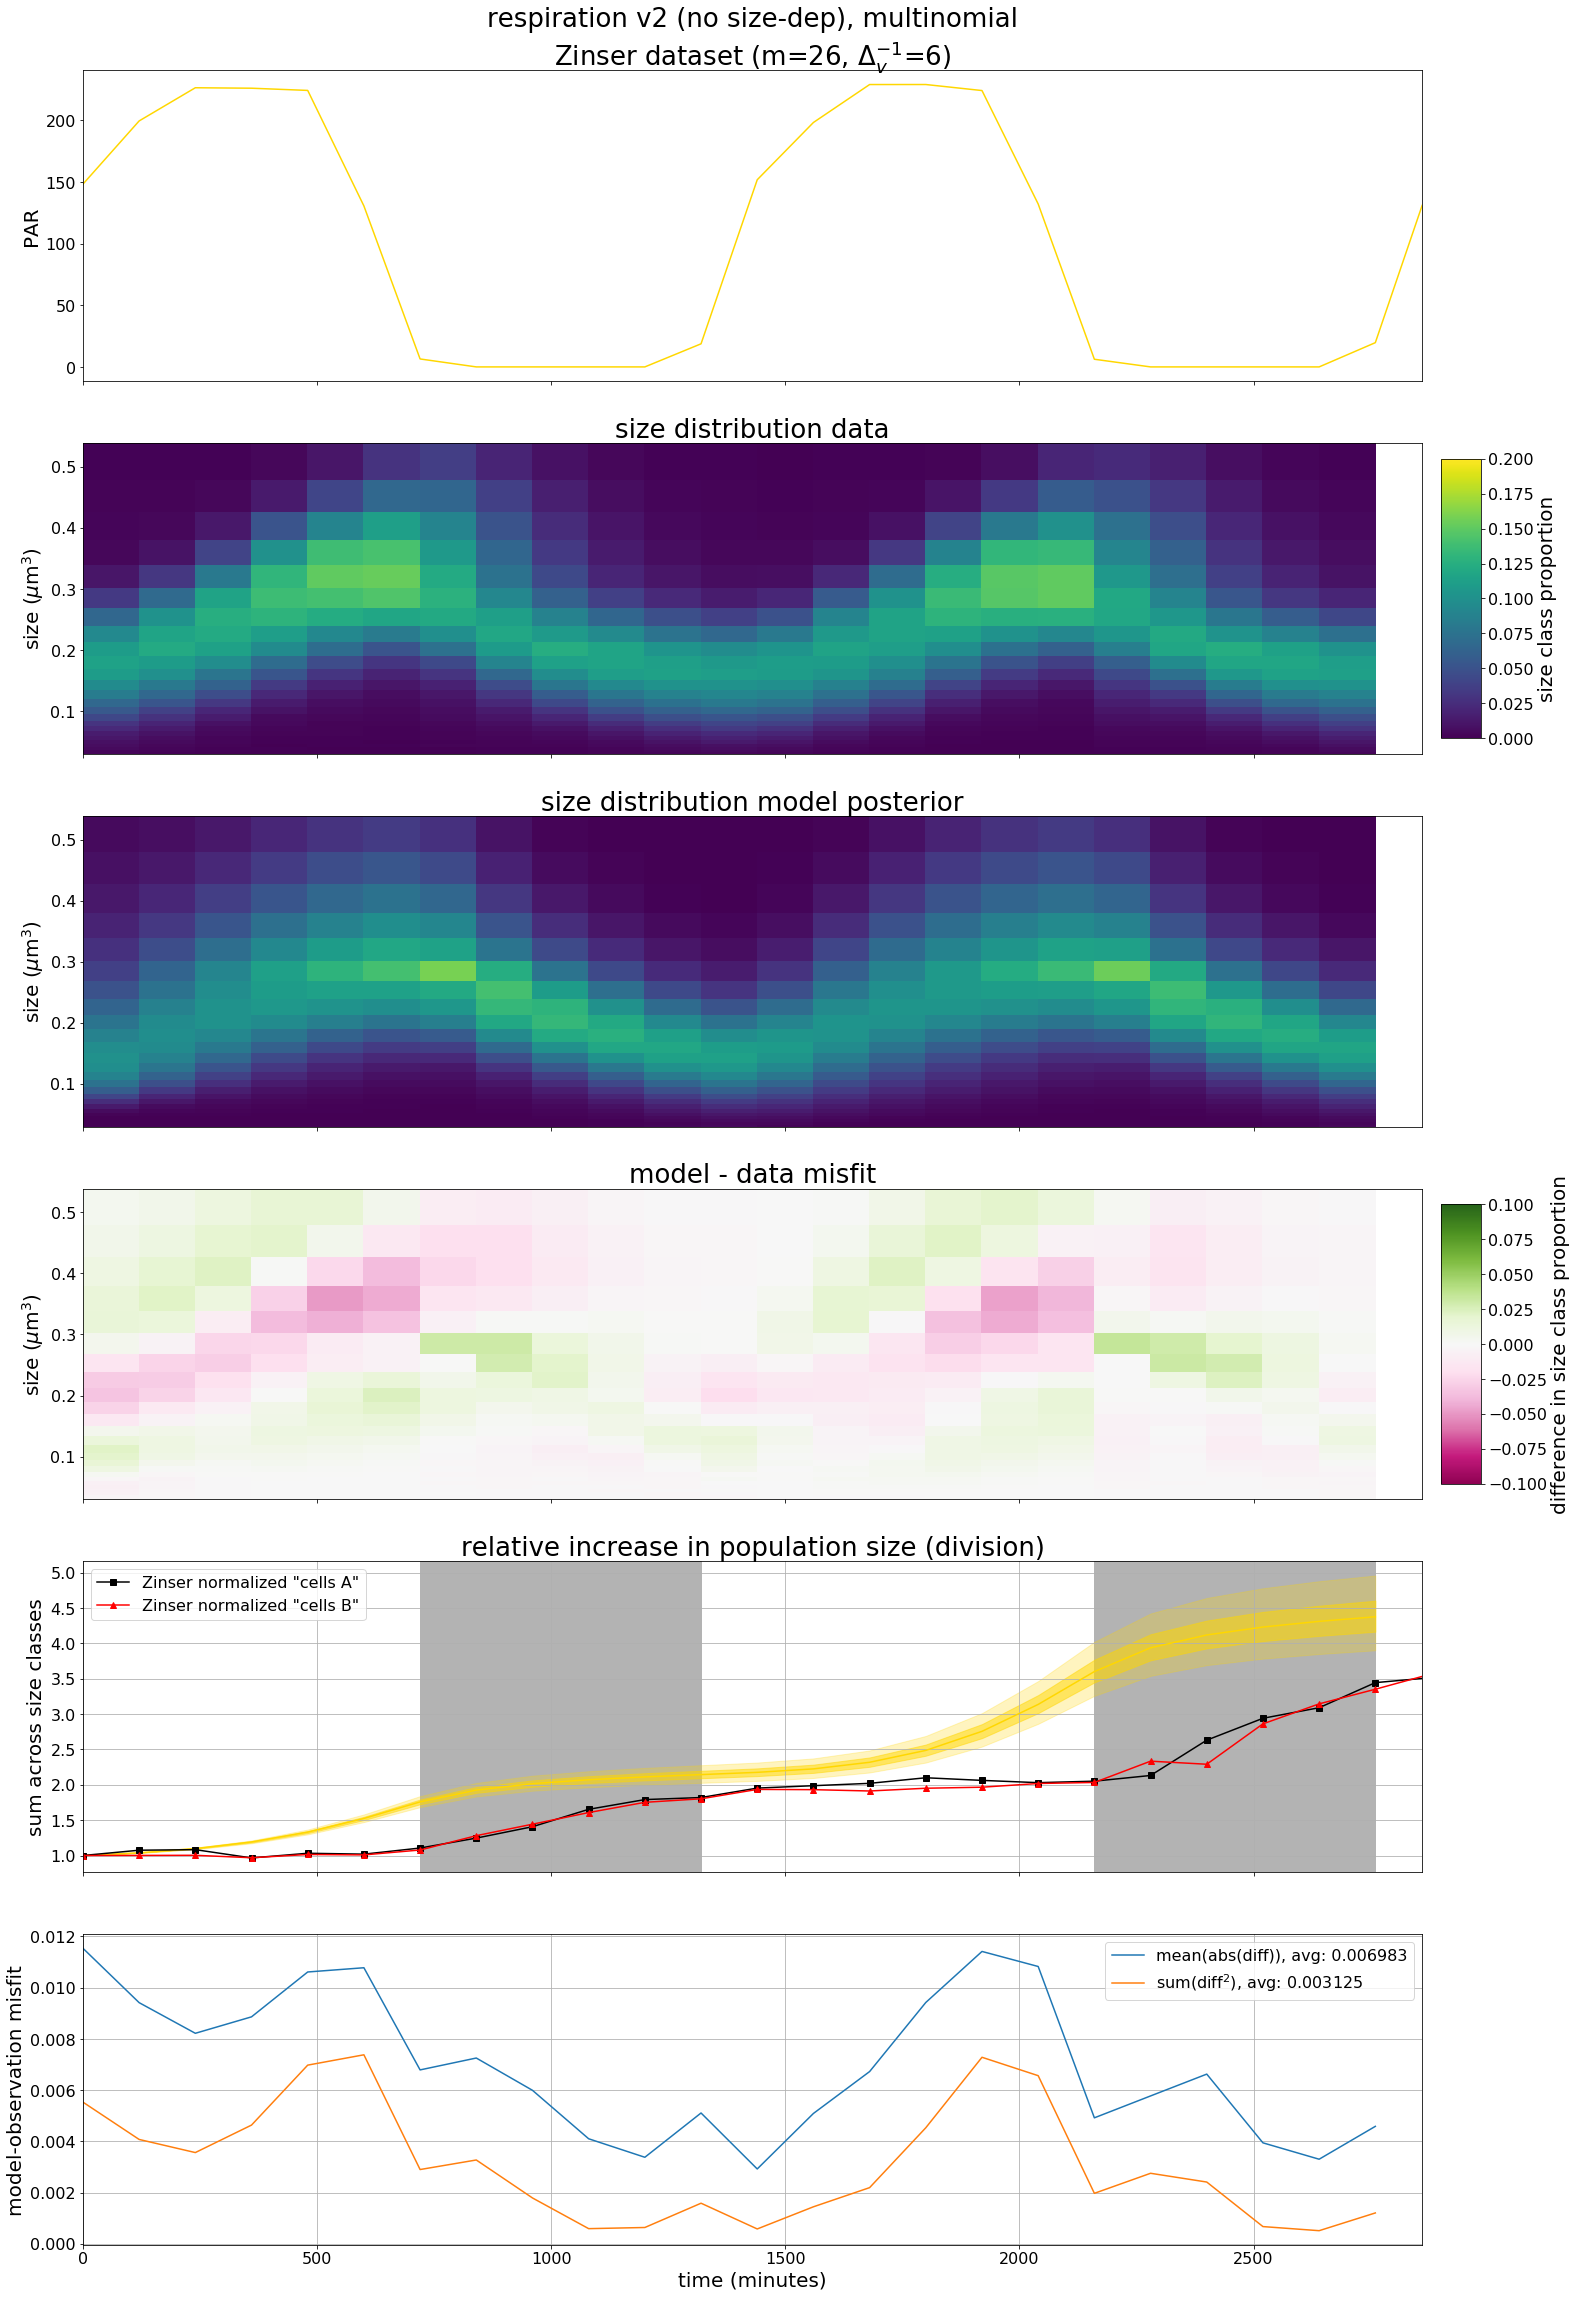

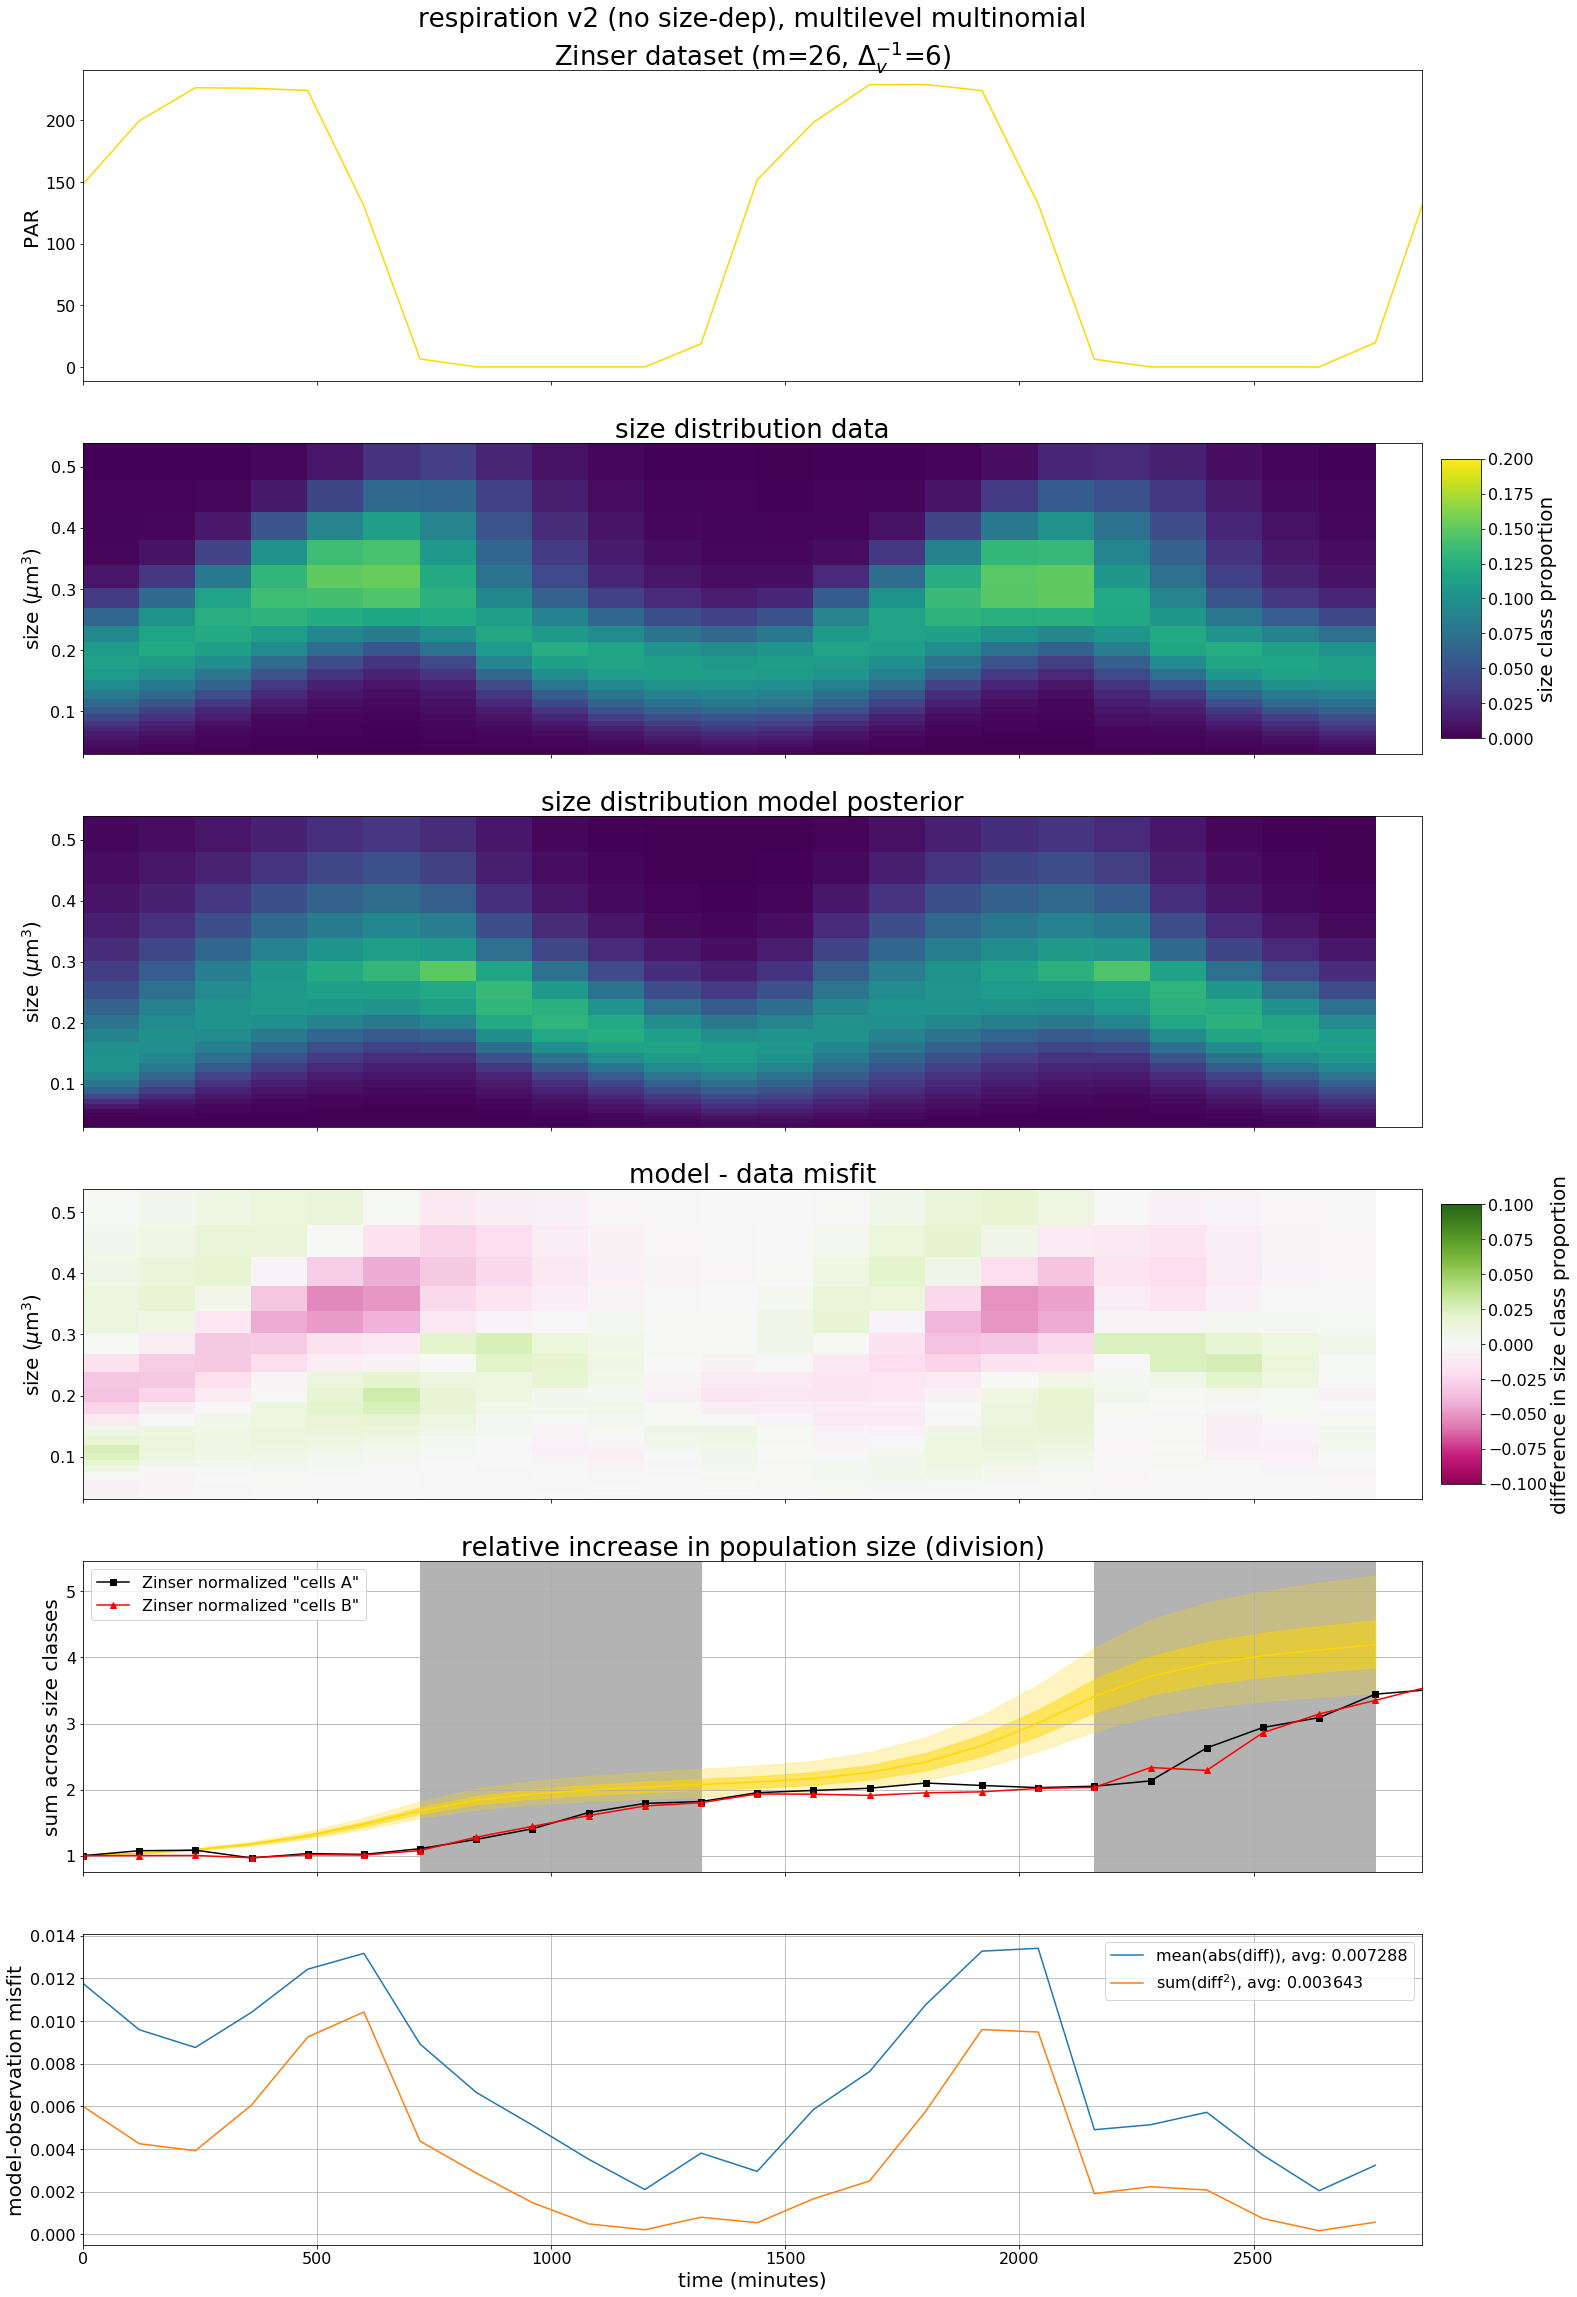

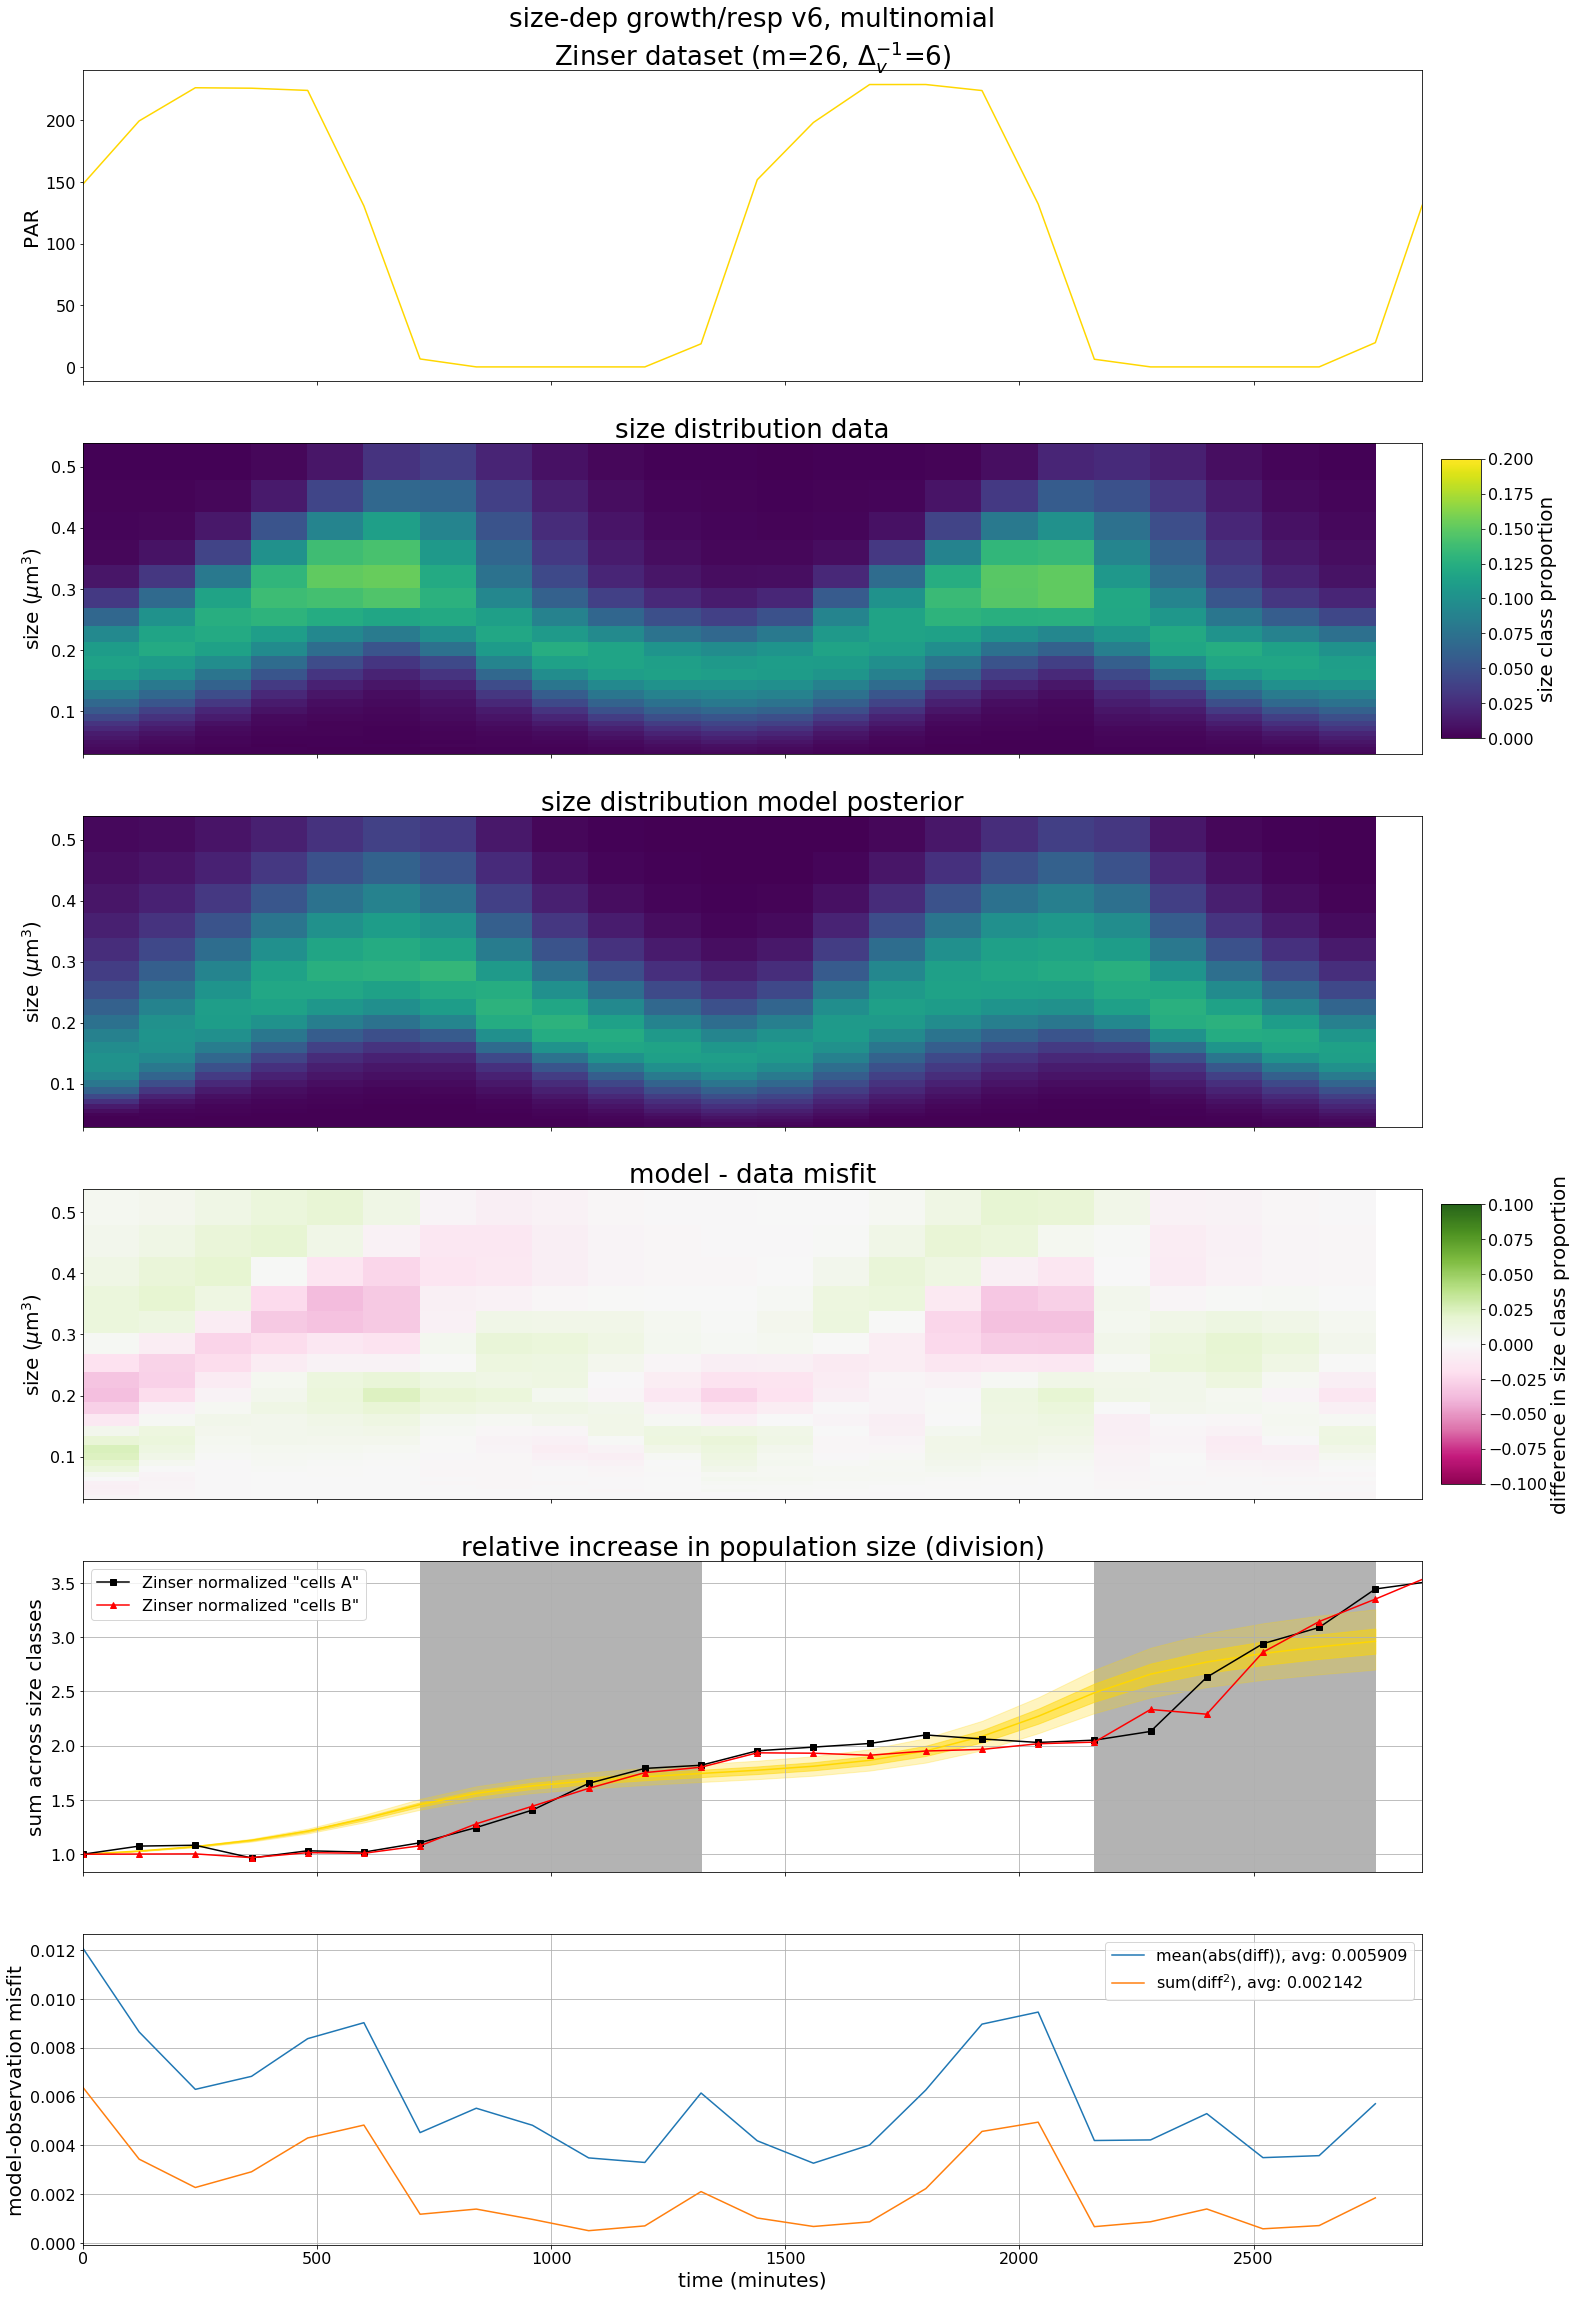

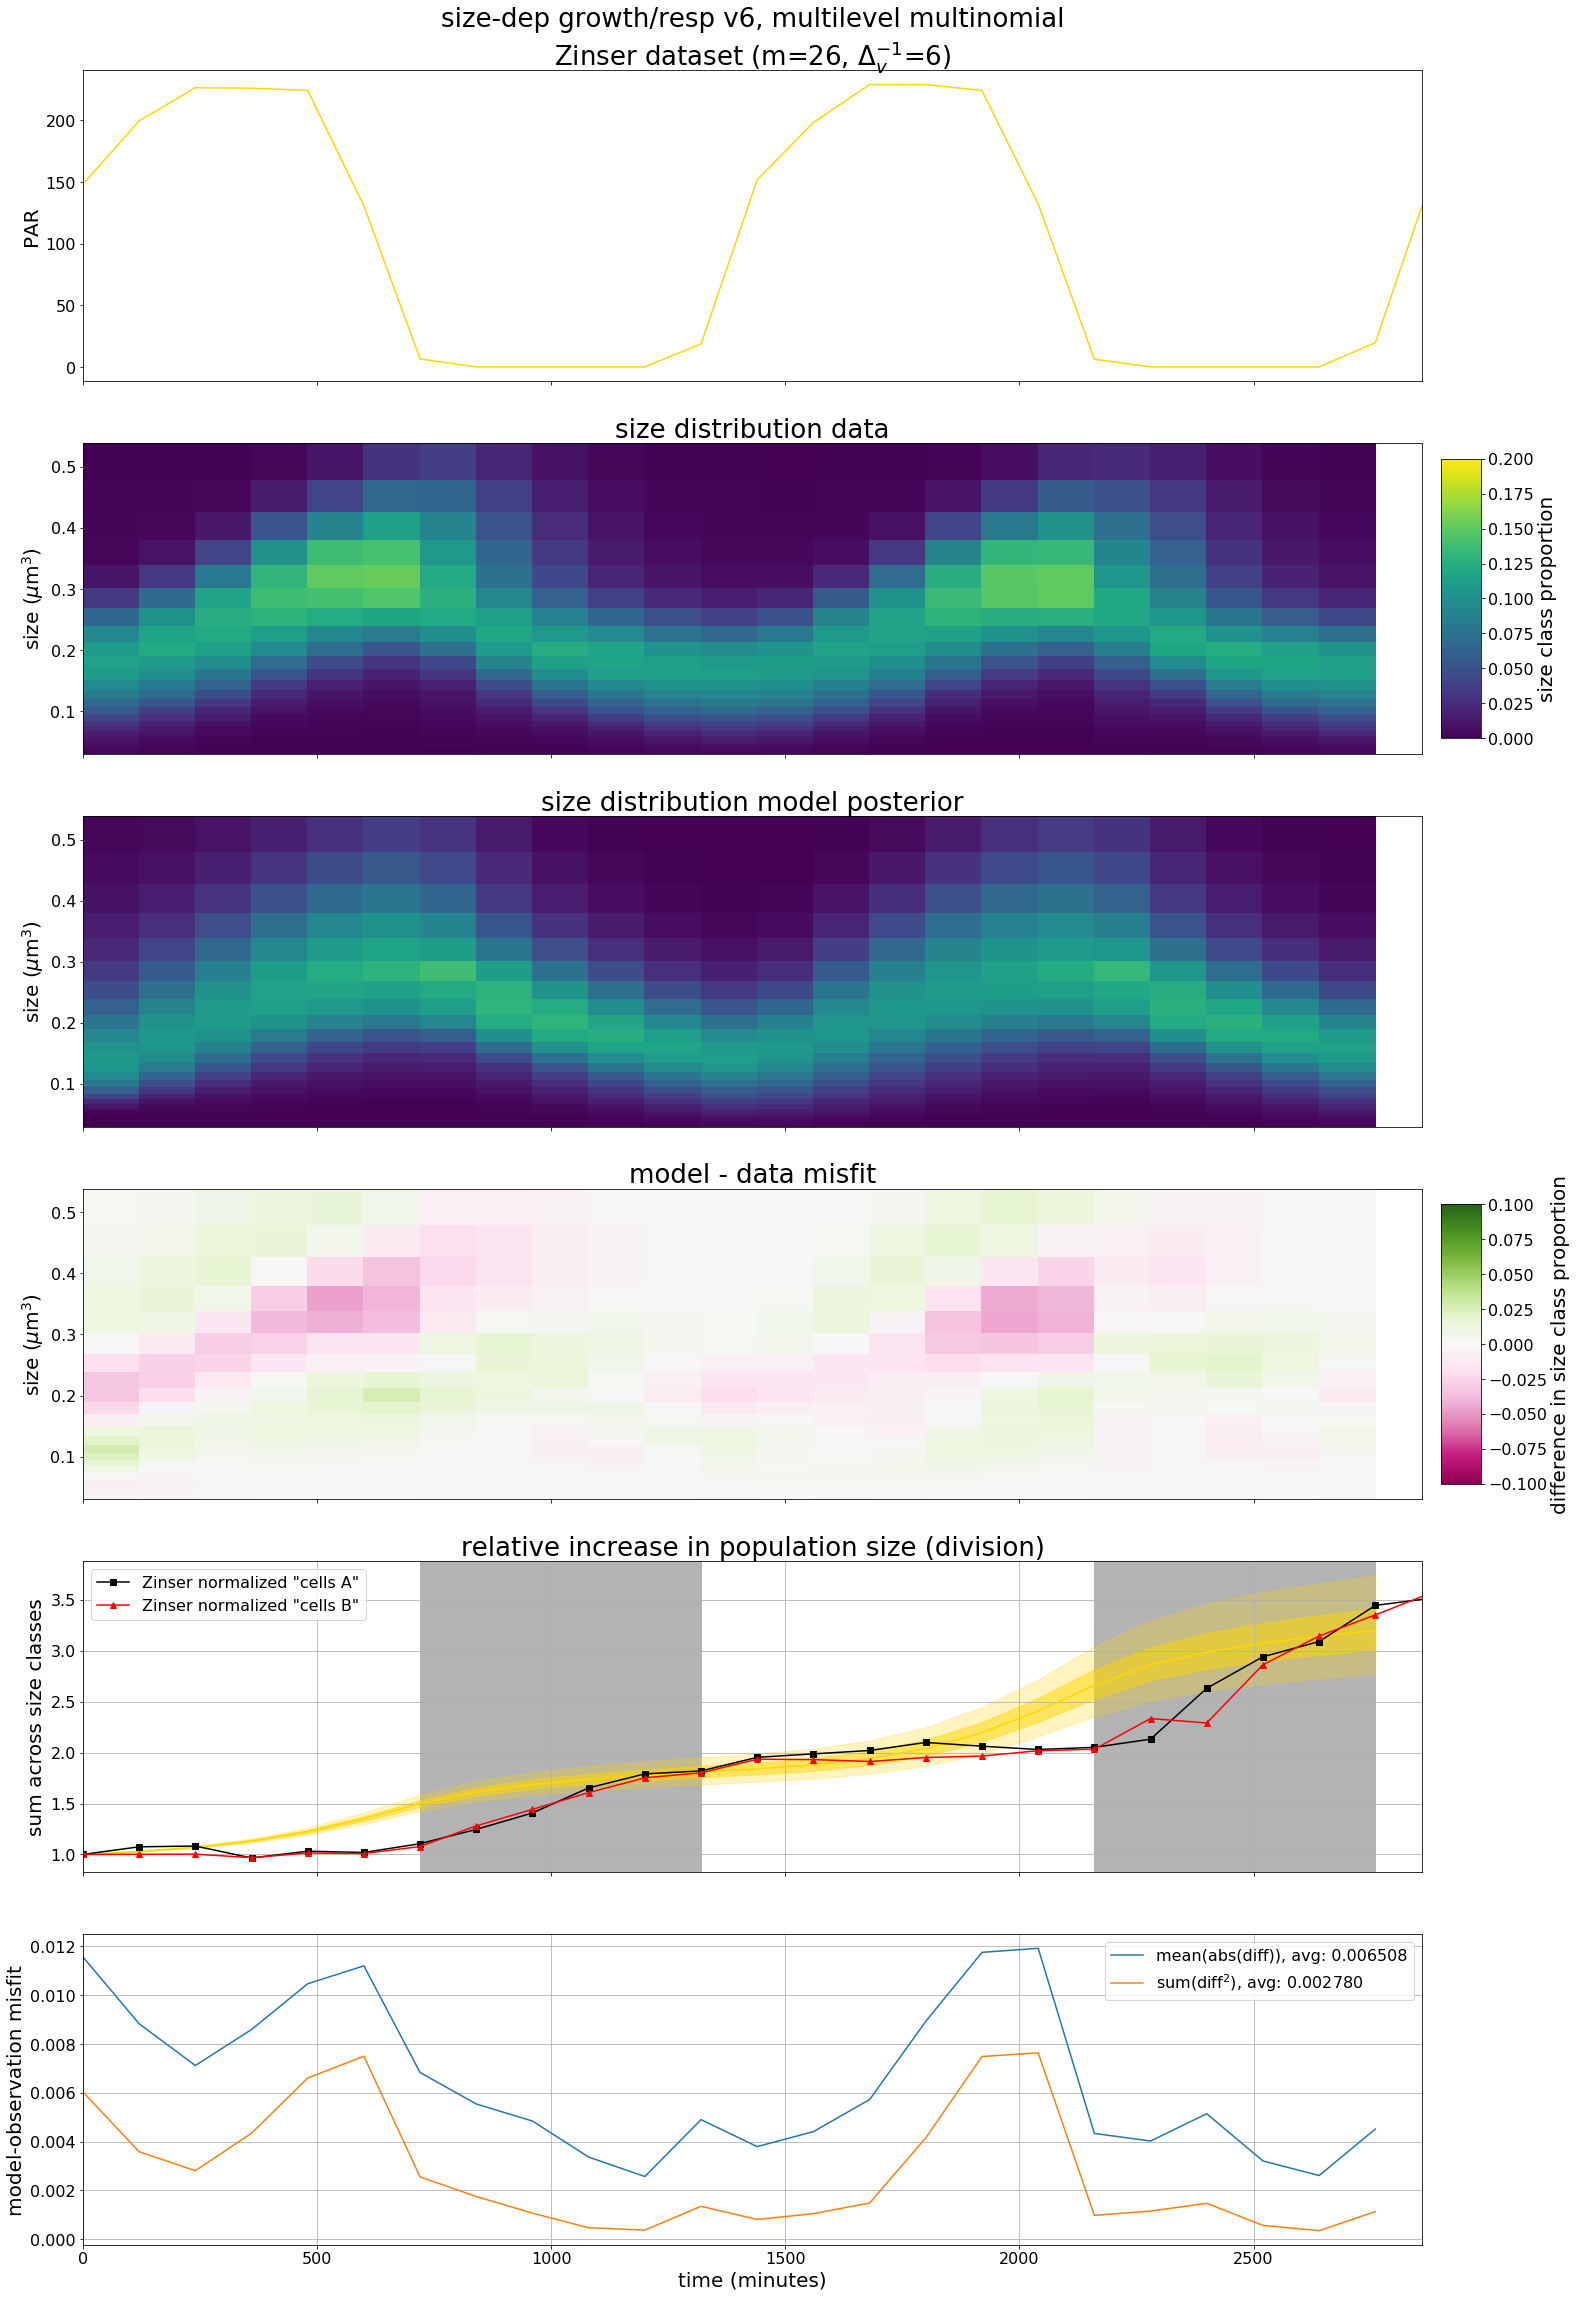

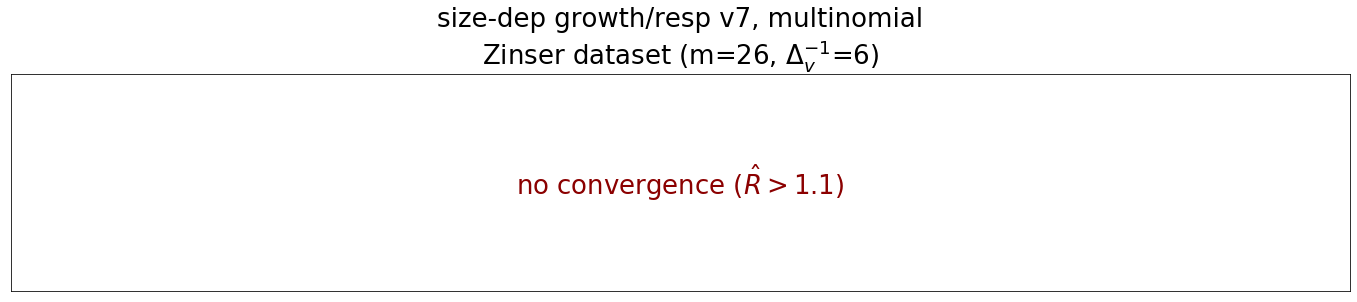

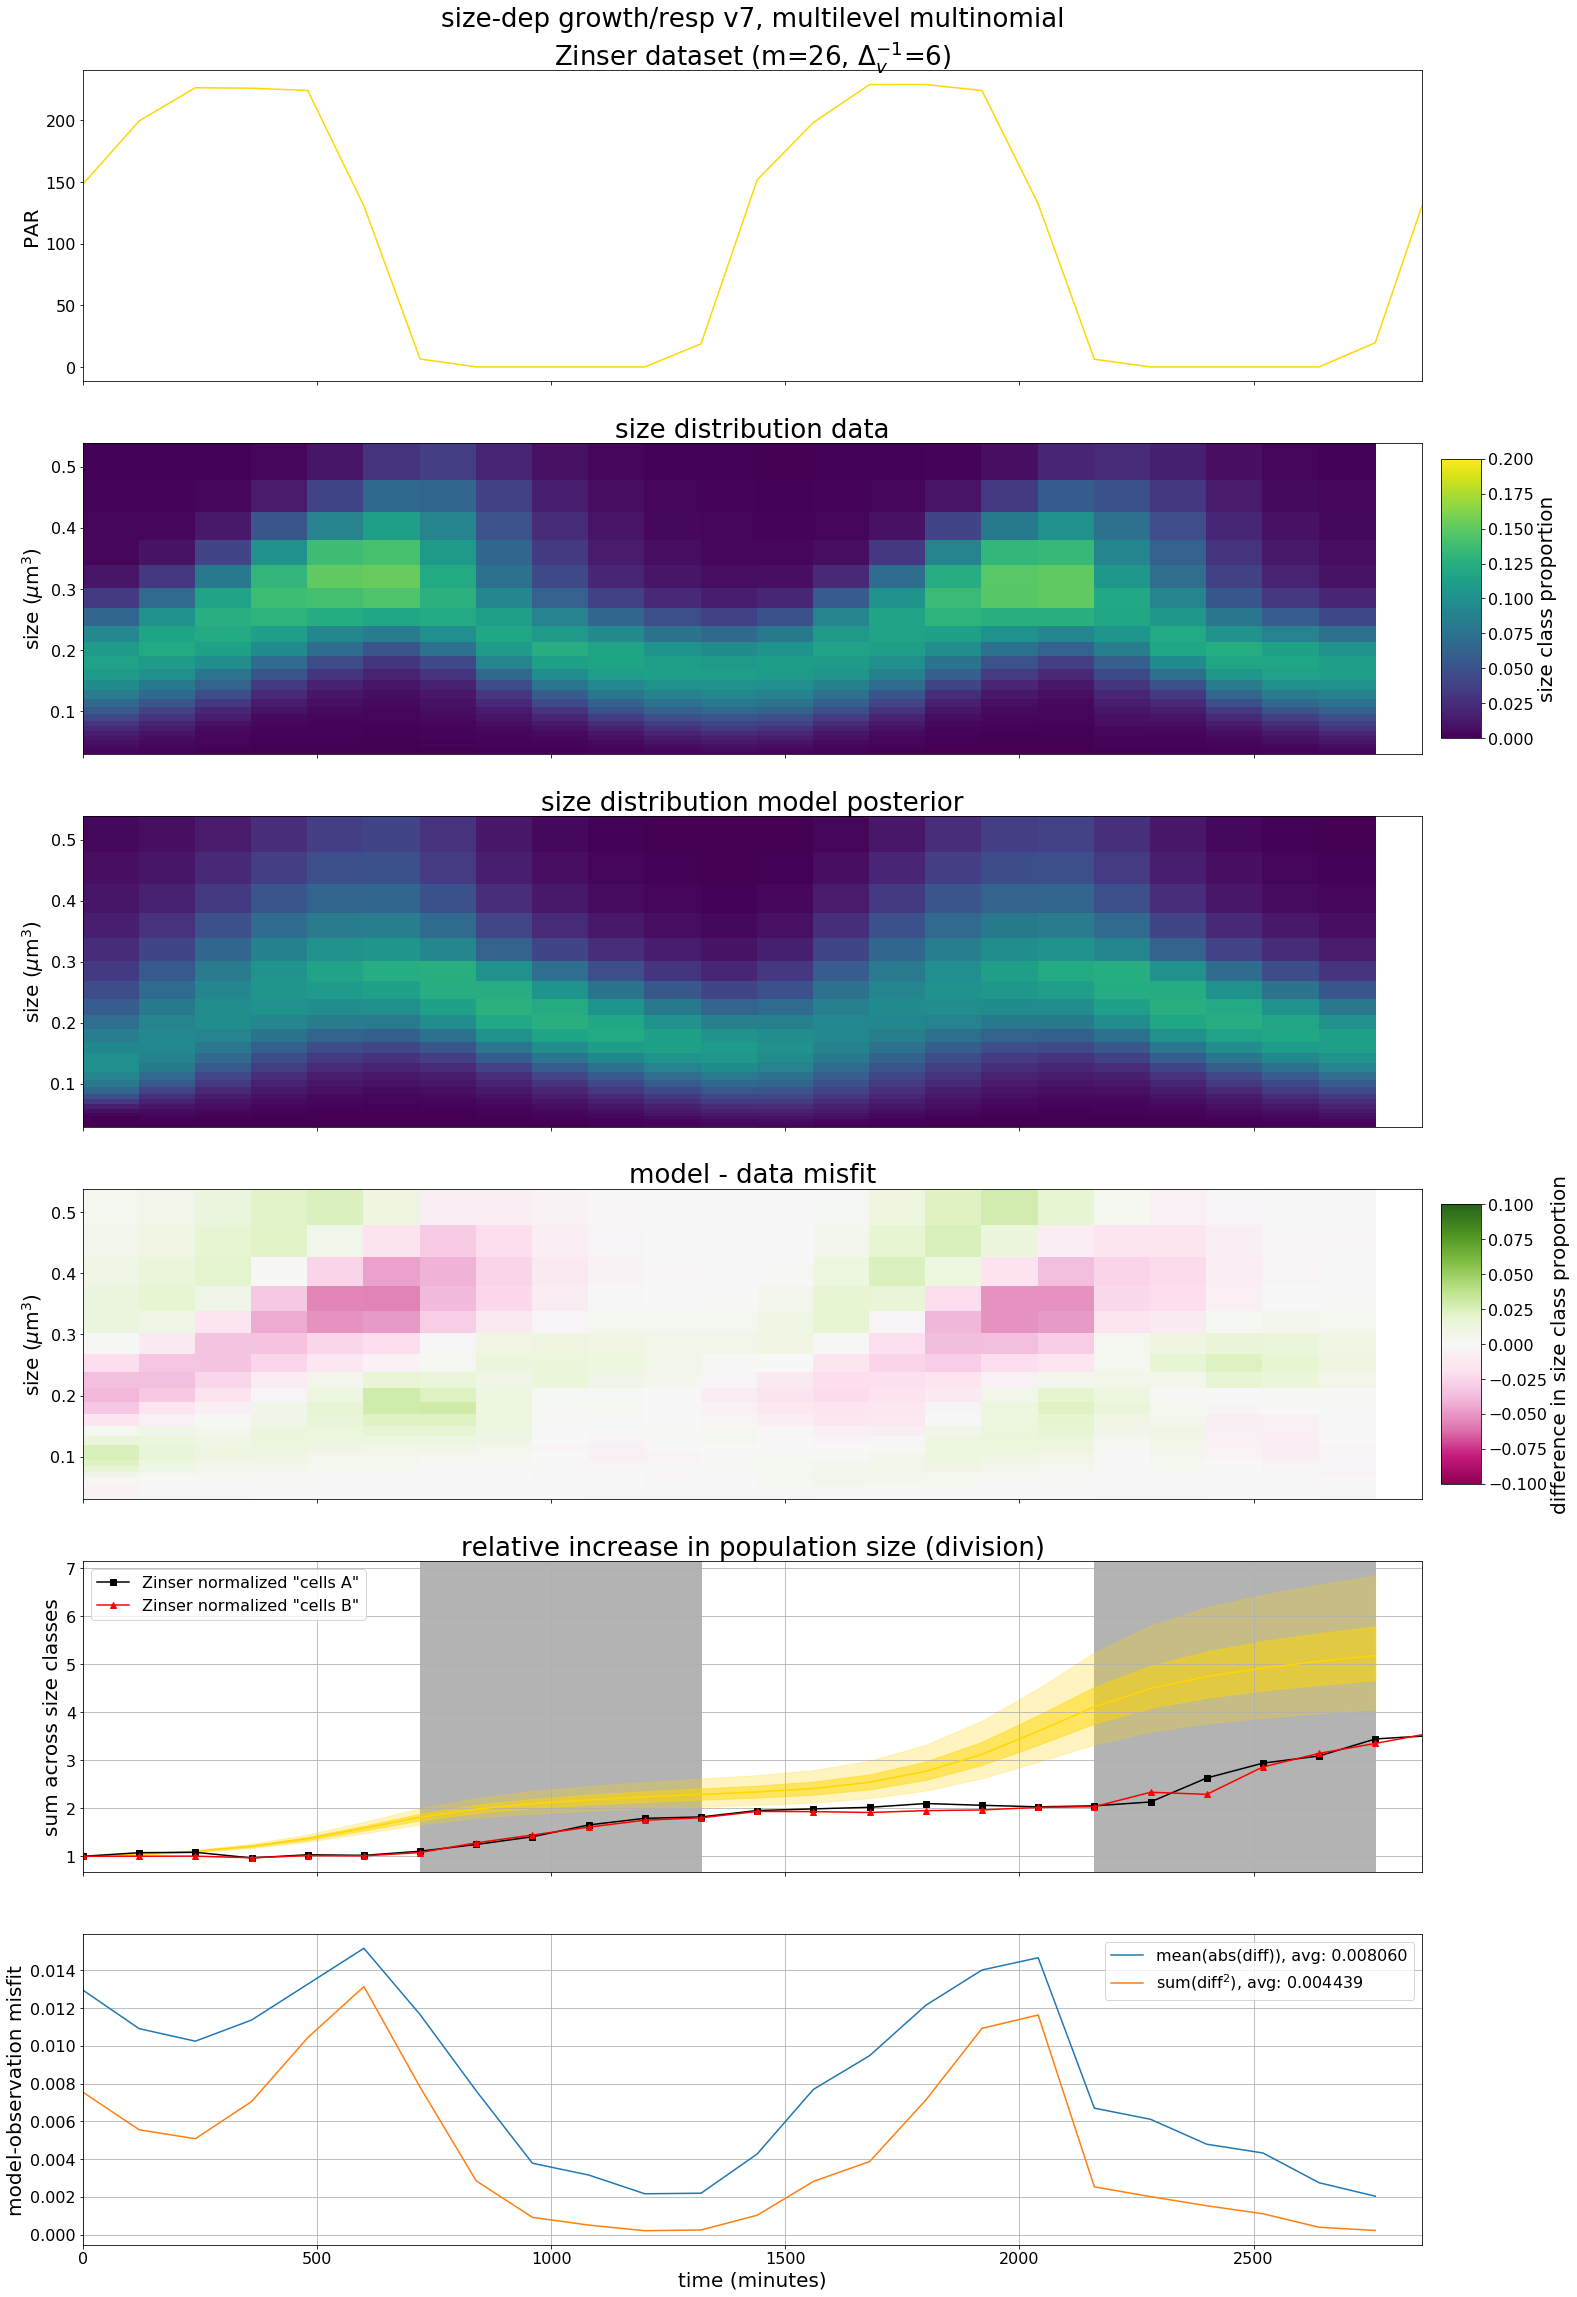

In [12]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()